## 📦 Step 0 — Install & Import Dependencies

In [60]:
# Install required libraries
!pip install tiktoken scikit-learn matplotlib seaborn pandas numpy torch --quiet
print("✅ All libraries installed successfully")

✅ All libraries installed successfully


In [61]:
# ── Core Imports ──
import re
import math
import time
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from collections import defaultdict
from typing import List, Dict, Tuple, Optional

# ── Sklearn ML Imports ──
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from scipy.sparse import issparse

warnings.filterwarnings("ignore")
print("✅ All imports successful")
print(f"   PyTorch version  : {torch.__version__}")
print(f"   NumPy version    : {np.__version__}")
print(f"   Pandas version   : {pd.__version__}")

✅ All imports successful
   PyTorch version  : 2.10.0+cpu
   NumPy version    : 2.0.2
   Pandas version   : 2.2.2


---
## 📚 Module 1 — Data Collection & Preprocessing

**Objective:** Load a rich corpus of text documents and prepare them for embedding generation.

We use a **built-in 30-document corpus** spanning 5 domains (Technology, Science, Health, Business, Education).  
This ensures the notebook runs **without any external file dependencies** in Google Colab.



In [62]:
# ══════════════════════════════════════════════════════════
# MODULE 1A — Built-in Corpus (30 documents, 5 categories)
# ══════════════════════════════════════════════════════════

CORPUS = [
    # ── Technology ──
    {"id":1,  "title":"Introduction to Machine Learning",
     "text":"Machine learning is a subset of artificial intelligence that enables computers to learn from data without being explicitly programmed. Algorithms build predictive models from training data to make decisions and predictions automatically.",
     "category":"Technology"},
    {"id":2,  "title":"Deep Learning and Neural Networks",
     "text":"Deep learning uses artificial neural networks with many hidden layers to learn complex patterns in data. Convolutional neural networks excel at image recognition while recurrent networks handle sequential data like text and speech.",
     "category":"Technology"},
    {"id":3,  "title":"Natural Language Processing",
     "text":"Natural language processing allows computers to understand interpret and generate human language. Core techniques include tokenization named entity recognition sentiment analysis and modern transformer-based language models.",
     "category":"Technology"},
    {"id":4,  "title":"Vector Embeddings in NLP",
     "text":"Word embeddings like Word2Vec and GloVe represent words as dense numerical vectors capturing semantic relationships. Sentence embeddings extend this concept to whole sentences enabling semantic similarity and search.",
     "category":"Technology"},
    {"id":5,  "title":"Transformer Architecture and BERT",
     "text":"Transformers use self-attention mechanisms to process sequential data efficiently in parallel. BERT and GPT models pre-trained on massive text corpora have revolutionized natural language understanding and generation tasks.",
     "category":"Technology"},
    {"id":6,  "title":"Information Retrieval Systems",
     "text":"Information retrieval systems help users find relevant documents from large collections efficiently. Traditional BM25 keyword matching is now complemented by dense vector embeddings for more accurate semantic search.",
     "category":"Technology"},
    {"id":7,  "title":"Recommendation Systems Design",
     "text":"Recommendation engines suggest relevant items to users based on their past behavior and preferences. Collaborative filtering content-based filtering and hybrid approaches power platforms like Netflix Spotify and Amazon.",
     "category":"Technology"},
    {"id":8,  "title":"Knowledge Graphs and Semantic Web",
     "text":"Knowledge graphs store entities and relationships in a graph structure enabling reasoning. They power semantic search question answering systems and help AI models reason over structured factual knowledge bases.",
     "category":"Technology"},
    {"id":9,  "title":"Computer Vision Techniques",
     "text":"Computer vision enables machines to interpret and understand visual information from images and videos. Key techniques include object detection image segmentation face recognition and generative adversarial networks.",
     "category":"Technology"},
    {"id":10, "title":"Reinforcement Learning Agents",
     "text":"Reinforcement learning trains agents to make sequential decisions by rewarding desired behaviors and penalizing bad ones. It has achieved superhuman performance in games and is applied in robotics and autonomous vehicles.",
     "category":"Technology"},
    # ── Science ──
    {"id":11, "title":"Quantum Computing Fundamentals",
     "text":"Quantum computers use qubits that can exist in superposition to perform computations simultaneously. Quantum entanglement and interference allow solving certain optimization and cryptography problems exponentially faster.",
     "category":"Science"},
    {"id":12, "title":"DNA and Genetic Sequencing",
     "text":"DNA sequencing determines the precise nucleotide order in a genome enabling personalized medicine. Next-generation sequencing technologies made genomics affordable leading to breakthroughs in disease diagnosis and treatment.",
     "category":"Science"},
    {"id":13, "title":"Climate Change and Global Warming",
     "text":"Anthropogenic greenhouse gas emissions are driving unprecedented global temperature increases. Rising sea levels extreme weather events and ecosystem collapse require urgent global transition to renewable energy sources.",
     "category":"Science"},
    {"id":14, "title":"Black Holes and Astrophysics",
     "text":"Black holes are cosmic regions where gravitational pull is so intense that not even light can escape the event horizon. Supermassive black holes reside at galactic centers and gravitational wave astronomy reveals mergers.",
     "category":"Science"},
    {"id":15, "title":"CRISPR Gene Editing Technology",
     "text":"CRISPR-Cas9 acts as molecular scissors enabling precise targeted editing of DNA sequences in living organisms. It holds transformative promise for treating inherited genetic diseases engineering crops and developing therapeutics.",
     "category":"Science"},
    # ── Health ──
    {"id":16, "title":"Mental Health and Wellbeing",
     "text":"Mental health encompasses emotional psychological and social wellbeing affecting cognition and behavior. Evidence-based approaches including cognitive behavioral therapy mindfulness meditation exercise and social connection improve outcomes.",
     "category":"Health"},
    {"id":17, "title":"Nutrition and Healthy Eating",
     "text":"Balanced nutrition requires adequate macronutrients proteins fats carbohydrates and essential micronutrients vitamins minerals. Mediterranean and whole-food plant-based diets reduce cardiovascular disease diabetes and improve longevity.",
     "category":"Health"},
    {"id":18, "title":"Exercise and Physical Fitness",
     "text":"Regular physical exercise reduces chronic disease risk improves mood through endorphin release and enhances cognitive function and memory consolidation. Combining aerobic training with resistance exercises yields optimal health benefits.",
     "category":"Health"},
    {"id":19, "title":"Vaccines and Immunology",
     "text":"Vaccines prime the adaptive immune system to produce protective antibodies and memory cells without causing active disease. Revolutionary mRNA vaccine technology enabled rapid COVID-19 vaccine development in record time.",
     "category":"Health"},
    {"id":20, "title":"Sleep Science and Disorders",
     "text":"Sleep is biologically essential for memory consolidation immune function hormonal regulation and metabolic health. Chronic sleep deprivation impairs cognition and increases disease risk. Insomnia and sleep apnea are prevalent disorders.",
     "category":"Health"},
    # ── Business ──
    {"id":21, "title":"Artificial Intelligence in Business",
     "text":"Enterprises deploy AI for intelligent automation customer service chatbots predictive analytics fraud detection and hyper-personalized marketing campaigns. AI-driven decision making measurably improves operational efficiency and revenue growth.",
     "category":"Business"},
    {"id":22, "title":"Digital Marketing Strategies",
     "text":"Modern digital marketing leverages SEO content marketing social media advertising email campaigns and influencer partnerships. Data analytics A/B testing and conversion rate optimization maximize campaign performance and measurable ROI.",
     "category":"Business"},
    {"id":23, "title":"Blockchain and Cryptocurrency",
     "text":"Blockchain is a decentralized distributed ledger enabling transparent immutable tamper-proof record keeping without central authority. Cryptocurrencies like Bitcoin and Ethereum enable peer-to-peer financial transactions and smart contracts.",
     "category":"Business"},
    {"id":24, "title":"Supply Chain Management",
     "text":"Supply chain management orchestrates coordinated flow of raw materials manufacturing logistics and delivery to end customers. AI machine learning and IoT sensors improve demand forecasting inventory optimization and logistics network efficiency.",
     "category":"Business"},
    {"id":25, "title":"Entrepreneurship and Startups",
     "text":"Startups pursue high-growth disruptive innovation with scalable and repeatable business models under conditions of uncertainty. Lean startup methodology emphasizes rapid prototyping customer discovery and iterative pivoting to achieve product-market fit.",
     "category":"Business"},
    # ── Education ──
    {"id":26, "title":"Online Learning and EdTech",
     "text":"Online education platforms revolutionize learning through video lectures interactive assessments peer collaboration and instant feedback. Adaptive learning algorithms personalize content difficulty and pacing based on individual student performance data.",
     "category":"Education"},
    {"id":27, "title":"Critical Thinking and Problem Solving",
     "text":"Critical thinking involves systematic objective analysis of information to form reasoned judgments and sound decisions. Core skills include logical reasoning identifying cognitive biases evaluating evidence and structured creative problem solving.",
     "category":"Education"},
    {"id":28, "title":"Data Science and Analytics",
     "text":"Data science integrates statistics mathematics programming and domain expertise to extract actionable insights from complex datasets. The full pipeline encompasses data collection cleaning exploratory analysis feature engineering modeling evaluation and communication.",
     "category":"Education"},
    {"id":29, "title":"Python Programming Language",
     "text":"Python is a versatile interpreted high-level programming language renowned for its readable clean syntax and expressive power. Its rich scientific ecosystem including NumPy Pandas Scikit-learn TensorFlow and PyTorch dominates data science and AI development.",
     "category":"Education"},
    {"id":30, "title":"Statistics and Probability Theory",
     "text":"Statistics provides mathematical frameworks for collecting analyzing interpreting and drawing conclusions from data. Probability theory underpins all machine learning algorithms. Key methods include hypothesis testing regression analysis and Bayesian inference.",
     "category":"Education"},
]

# Load into DataFrame
df = pd.DataFrame(CORPUS)
df["full_text"] = df["title"] + ". " + df["text"]

print(f"✅ Corpus loaded: {len(df)} documents")
print(f"   Categories     : {df['category'].unique().tolist()}")
print(f"   Docs per cat   : {dict(df['category'].value_counts())}")
print()
print("── Sample Document ──")
print(f"  ID       : {df.iloc[0]['id']}")
print(f"  Title    : {df.iloc[0]['title']}")
print(f"  Category : {df.iloc[0]['category']}")
print(f"  Text     : {df.iloc[0]['text'][:120]}...")
df.head()

✅ Corpus loaded: 30 documents
   Categories     : ['Technology', 'Science', 'Health', 'Business', 'Education']
   Docs per cat   : {'Technology': np.int64(10), 'Science': np.int64(5), 'Health': np.int64(5), 'Business': np.int64(5), 'Education': np.int64(5)}

── Sample Document ──
  ID       : 1
  Title    : Introduction to Machine Learning
  Category : Technology
  Text     : Machine learning is a subset of artificial intelligence that enables computers to learn from data without being explicit...


,id,title,text,category,full_text
0,1,Introduction to Machine Learning,Machine learning is a subset of artificia...,Technology,Introduction to Machine Learning. Machine...
1,2,Deep Learning and Neural Networks,Deep learning uses artificial neural netw...,Technology,Deep Learning and Neural Networks. Deep l...
2,3,Natural Language Processing,Natural language processing allows comput...,Technology,Natural Language Processing. Natural lang...
3,4,Vector Embeddings in NLP,Word embeddings like Word2Vec and GloVe r...,Technology,Vector Embeddings in NLP. Word embeddings...
4,5,Transformer Architecture and BERT,Transformers use self-attention mechanism...,Technology,Transformer Architecture and BERT. Transf...


In [63]:
# ══════════════════════════════════════════════════════════
# MODULE 1B — Text Preprocessing Pipeline
# ══════════════════════════════════════════════════════════

class TextPreprocessor:
    """
    Full NLP preprocessing pipeline:
      1. Lowercase conversion
      2. Special character removal (regex)
      3. Whitespace normalization
      4. Stopword removal
      5. Minimum token length filtering
    """

    STOPWORDS = {
        'a','an','the','is','it','in','on','at','to','for','of','and','or','but',
        'not','with','this','that','are','was','were','be','been','have','has','had',
        'do','does','did','will','would','could','should','may','might','can','about',
        'from','by','as','into','each','more','most','other','some','such','than',
        'then','when','where','while','who','which','its','our','their','your','my',
        'we','they','he','she','you','i','up','out','if','so','no','just','also',
        'these','those','there','here','use','used','using','make','made','very',
        'well','new','many','through','between','after','before','during','both',
    }

    def __init__(self, remove_stopwords=True, min_token_len=3):
        self.remove_stopwords = remove_stopwords
        self.min_token_len = min_token_len

    def clean(self, text: str) -> str:
        """Lowercase + remove non-alphanumeric + normalize whitespace."""
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize(self, text: str) -> List[str]:
        """Split into tokens, apply stopword removal and length filter."""
        tokens = text.split()
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.STOPWORDS]
        tokens = [t for t in tokens if len(t) >= self.min_token_len]
        return tokens

    def process(self, text: str) -> str:
        """Full pipeline → returns clean token string."""
        return ' '.join(self.tokenize(self.clean(text)))

    def process_corpus(self, df: pd.DataFrame, column: str = 'full_text') -> pd.DataFrame:
        """Apply preprocessing to entire corpus DataFrame."""
        t0 = time.time()
        df = df.copy()
        df['processed'] = df[column].apply(self.process)
        print(f"✅ Preprocessed {len(df)} documents in {time.time()-t0:.3f}s")
        return df


# Instantiate and run
preprocessor = TextPreprocessor(remove_stopwords=True, min_token_len=3)
df = preprocessor.process_corpus(df, column='full_text')

# Show before/after comparison
print()
print("── Preprocessing Example ──")
raw = df.iloc[0]['full_text']
clean = df.iloc[0]['processed']
tokens = clean.split()
print(f"  ORIGINAL  ({len(raw)} chars)  : {raw[:120]}...")
print(f"  PROCESSED ({len(clean)} chars) : {clean[:120]}...")
print(f"  TOKEN COUNT : {len(tokens)} tokens")
print(f"  SAMPLE TOKENS : {tokens[:15]}")

✅ Preprocessed 30 documents in 0.002s

── Preprocessing Example ──
  ORIGINAL  (271 chars)  : Introduction to Machine Learning. Machine learning is a subset of artificial intelligence that enables computers to lear...
  PROCESSED (227 chars) : introduction machine learning machine learning subset artificial intelligence enables computers learn data without being...
  TOKEN COUNT : 25 tokens
  SAMPLE TOKENS : ['introduction', 'machine', 'learning', 'machine', 'learning', 'subset', 'artificial', 'intelligence', 'enables', 'computers', 'learn', 'data', 'without', 'being', 'explicitly']


In [64]:
# ══════════════════════════════════════════════════════════
# MODULE 1C — Tokenization with tiktoken (from your notebook)
# ══════════════════════════════════════════════════════════
# We keep your original tiktoken tokenization to show the
# difference between BPE tokenization and NLP preprocessing.

tokenizer = tiktoken.get_encoding("gpt2")

# Encode the full corpus combined text
all_text = " ".join(df['full_text'].tolist())
encoded_ids = tokenizer.encode(all_text)

print("── tiktoken (GPT-2 BPE) Tokenization ──")
print(f"  Total characters : {len(all_text):,}")
print(f"  Total BPE tokens : {len(encoded_ids):,}")
print(f"  Vocabulary size  : {tokenizer.n_vocab:,}")
print(f"  Compression ratio: {len(all_text)/len(encoded_ids):.2f} chars/token")

# Decode a sample
sample_ids = encoded_ids[:40]
print()
print("── Sample Token IDs (first 40) ──")
print(sample_ids)
print()
print("── Decoded back ──")
print(tokenizer.decode(sample_ids))

── tiktoken (GPT-2 BPE) Tokenization ──
  Total characters : 7,965
  Total BPE tokens : 1,235
  Vocabulary size  : 50,257
  Compression ratio: 6.45 chars/token

── Sample Token IDs (first 40) ──
[21906, 284, 10850, 18252, 13, 10850, 4673, 318, 257, 24637, 286, 11666, 4430, 326, 13536, 9061, 284, 2193, 422, 1366, 1231, 852, 11777, 27402, 13, 978, 7727, 907, 1382, 33344, 4981, 422, 3047, 1366, 284, 787, 5370, 290, 16277, 6338]

── Decoded back ──
Introduction to Machine Learning. Machine learning is a subset of artificial intelligence that enables computers to learn from data without being explicitly programmed. Algorithms build predictive models from training data to make decisions and predictions automatically


In [65]:
# ══════════════════════════════════════════════════════════
# MODULE 1D — PyTorch Dataset & DataLoader (from your notebook)
# ══════════════════════════════════════════════════════════

class GPTDataset(Dataset):
    """
    Sliding window dataset for language modelling.
    Creates (input_chunk, target_chunk) pairs where target is
    input shifted by 1 position — standard next-token prediction.
    """
    def __init__(self, token_ids: List[int], max_length: int = 64, stride: int = 32):
        self.input_ids = []
        self.target_ids = []
        for i in range(0, len(token_ids) - max_length, stride):
            self.input_ids.append(torch.tensor(token_ids[i : i + max_length]))
            self.target_ids.append(torch.tensor(token_ids[i+1 : i + max_length + 1]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


# Build dataset and dataloader
MAX_LENGTH = 64
STRIDE     = 32
BATCH_SIZE = 8

dataset    = GPTDataset(encoded_ids, max_length=MAX_LENGTH, stride=STRIDE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

batch = next(iter(dataloader))
inputs, targets = batch

print("── PyTorch Dataset Stats ──")
print(f"  Total sliding windows (samples) : {len(dataset):,}")
print(f"  Batch size                      : {BATCH_SIZE}")
print(f"  Input  batch shape              : {inputs.shape}   → (batch, seq_len)")
print(f"  Target batch shape              : {targets.shape}   → (batch, seq_len)")
print()
print("── Sample Input/Target Pair (first 5 tokens of batch[0]) ──")
for i in range(5):
    in_tok  = tokenizer.decode([inputs[0][i].item()])
    tgt_tok = tokenizer.decode([targets[0][i].item()])
    print(f"  Token ID: {inputs[0][i].item():6d} → {targets[0][i].item():6d}   |   '{in_tok}' → '{tgt_tok}'")

── PyTorch Dataset Stats ──
  Total sliding windows (samples) : 37
  Batch size                      : 8
  Input  batch shape              : torch.Size([8, 64])   → (batch, seq_len)
  Target batch shape              : torch.Size([8, 64])   → (batch, seq_len)

── Sample Input/Target Pair (first 5 tokens of batch[0]) ──
  Token ID:   1127 →   6994   |   'ines' → ' prime'
  Token ID:   6994 →    262   |   ' prime' → ' the'
  Token ID:    262 →  29605   |   ' the' → ' adaptive'
  Token ID:  29605 →  10900   |   ' adaptive' → ' immune'
  Token ID:  10900 →   1080   |   ' immune' → ' system'


---
## 🧮 Module 2 — Vector Embedding Generation

We generate embeddings using **three complementary approaches**:



In [66]:
# ══════════════════════════════════════════════════════════
# MODULE 2A — PyTorch nn.Embedding (from your notebook, extended)
# ══════════════════════════════════════════════════════════

VOCAB_SIZE    = tokenizer.n_vocab   # 50257 (GPT-2 vocab)
EMBEDDING_DIM = 128

# Token Embedding Layer
token_embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)

# Positional Embedding Layer (NEW — positions 0..MAX_LENGTH-1)
pos_embedding = nn.Embedding(MAX_LENGTH, EMBEDDING_DIM)

# Forward pass: token + positional embeddings
sample_input = inputs  # shape: (8, 64)
positions    = torch.arange(MAX_LENGTH).unsqueeze(0).expand(BATCH_SIZE, -1)  # (8, 64)

token_emb = token_embedding(sample_input)  # (8, 64, 128)
pos_emb   = pos_embedding(positions)       # (8, 64, 128)
combined  = token_emb + pos_emb            # (8, 64, 128) — combined representation

print("── PyTorch Embedding Shapes ──")
print(f"  Embedding weight matrix     : {token_embedding.weight.shape}  → (vocab_size × embed_dim)")
print(f"  Positional embed matrix     : {pos_embedding.weight.shape}     → (max_len × embed_dim)")
print(f"  Token embedding output      : {token_emb.shape}    → (batch × seq_len × embed_dim)")
print(f"  Positional embedding output : {pos_emb.shape}    → (batch × seq_len × embed_dim)")
print(f"  Combined (tok + pos)        : {combined.shape}    → (batch × seq_len × embed_dim)")
print()

# Linear projection head (lm_head)
lm_head = nn.Linear(EMBEDDING_DIM, VOCAB_SIZE)
logits  = lm_head(combined)
print(f"  LM head logits shape        : {logits.shape}  → (batch × seq_len × vocab_size)")
print()
print("── Interpretation ──")
print("  Each of the 64 token positions has a 128-dim embedding vector.")
print("  The lm_head projects back to vocab_size for next-token prediction.")
print("  NOTE: These are RANDOM weights — not yet trained for semantics.")

── PyTorch Embedding Shapes ──
  Embedding weight matrix     : torch.Size([50257, 128])  → (vocab_size × embed_dim)
  Positional embed matrix     : torch.Size([64, 128])     → (max_len × embed_dim)
  Token embedding output      : torch.Size([8, 64, 128])    → (batch × seq_len × embed_dim)
  Positional embedding output : torch.Size([8, 64, 128])    → (batch × seq_len × embed_dim)
  Combined (tok + pos)        : torch.Size([8, 64, 128])    → (batch × seq_len × embed_dim)

  LM head logits shape        : torch.Size([8, 64, 50257])  → (batch × seq_len × vocab_size)

── Interpretation ──
  Each of the 64 token positions has a 128-dim embedding vector.
  The lm_head projects back to vocab_size for next-token prediction.
  NOTE: These are RANDOM weights — not yet trained for semantics.


In [67]:
# ══════════════════════════════════════════════════════════
# MODULE 2B — TF-IDF Vectorization
# ══════════════════════════════════════════════════════════
# TF-IDF = Term Frequency × Inverse Document Frequency
# Captures how important each word is in each document
# relative to the entire corpus.

print("═"*55)
print("  TF-IDF VECTORIZATION")
print("═"*55)

tfidf_vectorizer = TfidfVectorizer(
    ngram_range  = (1, 2),      # unigrams + bigrams
    max_features = 3000,        # top 3000 terms by TF-IDF score
    sublinear_tf = True,        # use log(1+tf) — dampens very frequent terms
    min_df       = 1,           # minimum document frequency
    max_df       = 0.95,        # ignore terms in >95% of docs (too common)
    strip_accents= 'unicode',
    analyzer     = 'word',
)

processed_texts = df['processed'].tolist()
tfidf_matrix    = tfidf_vectorizer.fit_transform(processed_texts)
vocab           = tfidf_vectorizer.get_feature_names_out()

print(f"\n  Documents        : {tfidf_matrix.shape[0]}")
print(f"  Vocabulary size  : {len(vocab):,} terms")
print(f"  Matrix shape     : {tfidf_matrix.shape}  (sparse)")
print(f"  Matrix density   : {tfidf_matrix.nnz / (tfidf_matrix.shape[0]*tfidf_matrix.shape[1]):.4f} (most entries = 0)")
print(f"\n  Sample vocab terms: {list(vocab[:10])}")
print(f"  Sample vocab terms: {list(vocab[100:110])}")

# Show top TF-IDF terms for a specific document
doc_idx = 0
row = tfidf_matrix[doc_idx].toarray().flatten()
top_indices = np.argsort(row)[::-1][:10]
print(f"\n  Top TF-IDF terms for Doc #{df.iloc[doc_idx]['id']} — '{df.iloc[doc_idx]['title']}':")
for idx in top_indices:
    if row[idx] > 0:
        print(f"    {vocab[idx]:<30} {row[idx]:.4f}")

═══════════════════════════════════════════════════════
  TF-IDF VECTORIZATION
═══════════════════════════════════════════════════════

  Documents        : 30
  Vocabulary size  : 1,312 terms
  Matrix shape     : (30, 1312)  (sparse)
  Matrix density   : 0.0376 (most entries = 0)

  Sample vocab terms: ['accurate', 'accurate semantic', 'achieve', 'achieve product', 'achieved', 'achieved superhuman', 'actionable', 'actionable insights', 'active', 'active disease']
  Sample vocab terms: ['behavior evidence', 'behavior preferences', 'behavioral', 'behavioral therapy', 'behaviors', 'behaviors penalizing', 'being', 'being explicitly', 'benefits', 'bert']

  Top TF-IDF terms for Doc #1 — 'Introduction to Machine Learning':
    machine                        0.2090
    machine learning               0.2090
    learning                       0.1706
    data                           0.1534
    models training                0.1515
    computers learn                0.1515
    training data   

In [68]:
# ══════════════════════════════════════════════════════════
# MODULE 2C — LSA Embeddings via Truncated SVD
# ══════════════════════════════════════════════════════════
# TF-IDF produces high-dimensional sparse vectors.
# Truncated SVD (LSA) compresses them into dense low-dimensional
# semantic vectors — capturing LATENT TOPICS in the data.
#
# Formula:  X (N×M)  →  U·Σ·Vᵀ  →  keep top-K components
#           TF-IDF matrix → Dense semantic embeddings

print("═"*55)
print("  LSA / TRUNCATED SVD EMBEDDINGS")
print("═"*55)

N_COMPONENTS = 20   # number of latent semantic dimensions

svd_model = TruncatedSVD(
    n_components = N_COMPONENTS,
    random_state = 42,
    n_iter       = 10
)

# Fit and transform: sparse TF-IDF → dense LSA vectors
lsa_raw     = svd_model.fit_transform(tfidf_matrix)
lsa_vectors = normalize(lsa_raw, norm='l2')  # L2-normalize for cosine similarity

explained_var = svd_model.explained_variance_ratio_.sum()

print(f"\n  TF-IDF matrix shape  : {tfidf_matrix.shape}  (sparse, high-dim)")
print(f"  SVD components (K)   : {N_COMPONENTS}")
print(f"  LSA vectors shape    : {lsa_vectors.shape}  (dense, low-dim)")
print(f"  Explained variance   : {explained_var:.2%}")
print(f"  Compression ratio    : {tfidf_matrix.shape[1]} → {N_COMPONENTS} dims ({tfidf_matrix.shape[1]//N_COMPONENTS}× reduction)")
print()
print("  ── LSA Vector for Doc #1 (first 10 dims) ──")
print(f"  {lsa_vectors[0][:10].round(4)}")
print()
print("  ── Cosine Similarity (since L2-normalized, cosine = dot product) ──")
sim_1_2 = np.dot(lsa_vectors[0], lsa_vectors[1])
sim_1_16 = np.dot(lsa_vectors[0], lsa_vectors[15])
print(f"  Doc1 (ML) vs Doc2  (Deep Learning) : {sim_1_2:.4f}  ← high (same domain)")
print(f"  Doc1 (ML) vs Doc16 (Mental Health) : {sim_1_16:.4f}  ← low  (different domain)")

═══════════════════════════════════════════════════════
  LSA / TRUNCATED SVD EMBEDDINGS
═══════════════════════════════════════════════════════

  TF-IDF matrix shape  : (30, 1312)  (sparse, high-dim)
  SVD components (K)   : 20
  LSA vectors shape    : (30, 20)  (dense, low-dim)
  Explained variance   : 68.96%
  Compression ratio    : 1312 → 20 dims (65× reduction)

  ── LSA Vector for Doc #1 (first 10 dims) ──
  [ 0.6504 -0.2661 -0.086  -0.4036  0.0266 -0.1963  0.0147 -0.2805 -0.006
  0.0327]

  ── Cosine Similarity (since L2-normalized, cosine = dot product) ──
  Doc1 (ML) vs Doc2  (Deep Learning) : 0.4337  ← high (same domain)
  Doc1 (ML) vs Doc16 (Mental Health) : -0.1444  ← low  (different domain)


In [69]:
# ══════════════════════════════════════════════════════════
# MODULE 2D — Embedding Summary Comparison
# ══════════════════════════════════════════════════════════

print("═"*65)
print("  EMBEDDING COMPARISON SUMMARY")
print("═"*65)
print(f"{'Method':<30} {'Shape':<20} {'Type':<12} {'Semantic'}")
print("-"*65)
print(f"{'nn.Embedding (PyTorch)':<30} {'(50257, 128)':<20} {'Dense':<12} {'❌ Untrained'}")
print(f"{'TF-IDF (sklearn)':<30} {str(tfidf_matrix.shape):<20} {'Sparse':<12} {'Partial'}")
print(f"{'TF-IDF + SVD/LSA':<30} {str(lsa_vectors.shape):<20} {'Dense':<12} {'✅ Yes'}")
print("-"*65)
print()
print("  The LSA vectors (20-dim, normalized) capture semantic meaning")
print("  and will be used for all search, recommendation, and eval tasks.")

═════════════════════════════════════════════════════════════════
  EMBEDDING COMPARISON SUMMARY
═════════════════════════════════════════════════════════════════
Method                         Shape                Type         Semantic
-----------------------------------------------------------------
nn.Embedding (PyTorch)         (50257, 128)         Dense        ❌ Untrained
TF-IDF (sklearn)               (30, 1312)           Sparse       Partial
TF-IDF + SVD/LSA               (30, 20)             Dense        ✅ Yes
-----------------------------------------------------------------

  The LSA vectors (20-dim, normalized) capture semantic meaning
  and will be used for all search, recommendation, and eval tasks.


---
## 🗄️ Module 3 — Vector Storage & Indexing

**Objective:** Store document vectors efficiently and support fast similarity queries.

The `VectorStore` class maintains:
- The normalized LSA embedding matrix
- A **document ID → row index** mapping
- A **category index** (category → list of doc IDs)
- An **inverted index** (term → set of doc IDs) for keyword pre-filtering


In [70]:
# ══════════════════════════════════════════════════════════
# MODULE 3 — VectorStore: Storage, Indexing & Retrieval
# ══════════════════════════════════════════════════════════

class VectorStore:
    """
    Efficient vector storage with multiple index structures:
      - Dense vector matrix for cosine similarity search
      - Document ID → row index mapping
      - Category index: category → [doc_ids]
      - Inverted index: term → {doc_ids}  (for keyword pre-filtering)
    """

    def __init__(self):
        self.vectors          = None   # np.ndarray (N, D) — LSA embeddings
        self.documents        = None   # pd.DataFrame
        self.id_to_idx        = {}     # doc_id → row index
        self.inverted_index   = defaultdict(set)   # term → {doc_id, ...}
        self.category_index   = defaultdict(list)  # category → [doc_id, ...]

    def build(self, df: pd.DataFrame, vectors: np.ndarray):
        """Populate the store from a DataFrame and its embedding matrix."""
        assert len(df) == vectors.shape[0], "Mismatch: #docs != #vectors"
        self.vectors   = vectors
        self.documents = df.reset_index(drop=True)

        for i, row in self.documents.iterrows():
            doc_id = row['id']
            self.id_to_idx[doc_id] = i
            self.category_index[row.get('category', 'Unknown')].append(doc_id)
            for token in row.get('processed', '').split():
                self.inverted_index[token].add(doc_id)

        print(f"✅ VectorStore built successfully")
        print(f"   Documents      : {len(self.documents)}")
        print(f"   Vector shape   : {self.vectors.shape}")
        print(f"   Unique terms   : {len(self.inverted_index):,}")
        print(f"   Categories     : {dict({k: len(v) for k,v in self.category_index.items()})}")

    def get_vector(self, doc_id: int) -> np.ndarray:
        """Retrieve the LSA vector for a specific document."""
        return self.vectors[self.id_to_idx[doc_id]]

    def search(self, query_vec: np.ndarray, top_k: int = 5,
               category_filter: str = None, exclude_ids: List[int] = None) -> List[Dict]:
        """
        Cosine similarity search.
        Args:
          query_vec       : L2-normalized query embedding
          top_k           : number of results to return
          category_filter : restrict results to a specific category
          exclude_ids     : doc IDs to exclude (e.g., self in recommendations)
        Returns:
          List of result dicts sorted by similarity score descending
        """
        # Build candidate mask
        mask = np.ones(len(self.documents), dtype=bool)
        if category_filter:
            allowed = set(self.category_index.get(category_filter, []))
            for i, row in self.documents.iterrows():
                if row['id'] not in allowed:
                    mask[i] = False
        if exclude_ids:
            excl = set(exclude_ids)
            for i, row in self.documents.iterrows():
                if row['id'] in excl:
                    mask[i] = False

        # Compute cosine similarity against all candidates
        candidates  = self.vectors[mask]
        cand_docs   = self.documents[mask].reset_index()
        if len(candidates) == 0:
            return []

        scores  = cosine_similarity(query_vec.reshape(1, -1), candidates)[0]
        top_idx = np.argsort(scores)[::-1][:top_k]

        return [
            {
                "rank"     : r + 1,
                "doc_id"   : int(cand_docs.iloc[i]['id']),
                "title"    : cand_docs.iloc[i]['title'],
                "text"     : cand_docs.iloc[i]['text'],
                "category" : cand_docs.iloc[i].get('category', '?'),
                "score"    : float(scores[i]),
            }
            for r, i in enumerate(top_idx)
        ]

    def similarity_matrix(self) -> np.ndarray:
        """Compute the full N×N pairwise cosine similarity matrix."""
        return cosine_similarity(self.vectors)

    def keyword_candidates(self, tokens: List[str]) -> List[int]:
        """Return doc_ids containing any of the query tokens (inverted index lookup)."""
        candidates = set()
        for t in tokens:
            candidates |= self.inverted_index.get(t, set())
        return list(candidates)


# ── Build the store ──
store = VectorStore()
store.build(df, lsa_vectors)

# ── Demo: Look up a specific document vector ──
print()
print("── Sample vector for Doc #1 (Machine Learning) ──")
v = store.get_vector(1)
print(f"   Shape: {v.shape}")
print(f"   L2 norm: {np.linalg.norm(v):.4f}  (should be 1.0 — normalized)")
print(f"   First 8 dims: {v[:8].round(4)}")

# ── Demo: Keyword search via inverted index ──
print()
print("── Inverted Index Lookup: 'learning' ──")
hits = store.keyword_candidates(['learning'])
print(f"   Doc IDs containing 'learning': {sorted(hits)}")

✅ VectorStore built successfully
   Documents      : 30
   Vector shape   : (30, 20)
   Unique terms   : 567
   Categories     : {'Technology': 10, 'Science': 5, 'Health': 5, 'Business': 5, 'Education': 5}

── Sample vector for Doc #1 (Machine Learning) ──
   Shape: (20,)
   L2 norm: 1.0000  (should be 1.0 — normalized)
   First 8 dims: [ 0.6504 -0.2661 -0.086  -0.4036  0.0266 -0.1963  0.0147 -0.2805]

── Inverted Index Lookup: 'learning' ──
   Doc IDs containing 'learning': [1, 2, 10, 24, 26, 30]


---
## 🔍 Module 4 — Semantic Search Engine

**Objective:** Given a natural language query, find the most semantically relevant documents.



In [71]:
# ══════════════════════════════════════════════════════════
# MODULE 4A — SearchEngine Class
# ══════════════════════════════════════════════════════════

class SearchEngine:
    """
    Semantic search engine using LSA vector embeddings.
    Transforms user queries into the same embedding space as
    the document corpus and ranks by cosine similarity.
    """

    def __init__(self, preprocessor: TextPreprocessor,
                       tfidf: TfidfVectorizer,
                       svd: TruncatedSVD,
                       store: VectorStore):
        self.preprocessor = preprocessor
        self.tfidf        = tfidf
        self.svd          = svd
        self.store        = store

    def _embed_query(self, query: str) -> np.ndarray:
        """Preprocess → TF-IDF → SVD → L2-normalize → query vector."""
        processed  = self.preprocessor.process(query)
        tfidf_vec  = self.tfidf.transform([processed])
        lsa_vec    = self.svd.transform(tfidf_vec)
        return normalize(lsa_vec, norm='l2')[0]

    def search(self, query: str, top_k: int = 5,
               category: str = None) -> Dict:
        """
        Perform semantic search.
        Returns dict with query info + ranked results.
        """
        t0 = time.time()
        query_vec = self._embed_query(query)
        results   = self.store.search(query_vec, top_k=top_k, category_filter=category)
        elapsed   = time.time() - t0
        return {
            "query"             : query,
            "processed_query"   : self.preprocessor.process(query),
            "query_vector"      : query_vec,
            "results"           : results,
            "search_time_ms"    : round(elapsed * 1000, 2),
            "total_docs"        : len(self.store.documents),
        }

    def batch_search(self, queries: List[str], top_k: int = 3) -> List[Dict]:
        """Run multiple queries at once."""
        return [self.search(q, top_k=top_k) for q in queries]

    def print_results(self, result: Dict, show_text: bool = False):
        """Pretty-print search results to console."""
        q = result['query']
        t = result['search_time_ms']
        n = result['total_docs']
        print(f"\n{'='*65}")
        print(f"  QUERY : \"{q}\"")
        print(f"  Time  : {t}ms  |  Corpus: {n} docs")
        print(f"{'='*65}")
        for r in result['results']:
            bar = '█' * int(r['score'] * 25)
            print(f"  {r['rank']}. [{r['category']:<12}] {r['title']:<42}")
            print(f"     Score: {r['score']:.4f}  {bar}")
            if show_text:
                print(f"     {r['text'][:100]}...")
            print()


# ── Instantiate the search engine ──
search_engine = SearchEngine(preprocessor, tfidf_vectorizer, svd_model, store)
print("✅ SearchEngine initialized")
print("   Components: TextPreprocessor + TfidfVectorizer + TruncatedSVD + VectorStore")

✅ SearchEngine initialized
   Components: TextPreprocessor + TfidfVectorizer + TruncatedSVD + VectorStore


In [72]:
# ══════════════════════════════════════════════════════════
# MODULE 4B — Run Demo Searches
# ══════════════════════════════════════════════════════════

demo_queries = [
    "how do neural networks learn from data",
    "finding relevant documents using embeddings",
    "healthy diet and disease prevention",
    "python programming for data analysis",
    "space black holes universe physics",
    "business startup entrepreneurship innovation",
    "vaccine immune system protection disease",
    "online education learning platform students",
]

for q in demo_queries:
    result = search_engine.search(q, top_k=5)
    search_engine.print_results(result)


  QUERY : "how do neural networks learn from data"
  Time  : 4.51ms  |  Corpus: 30 docs
  1. [Technology  ] Deep Learning and Neural Networks         
     Score: 0.9754  ████████████████████████

  2. [Technology  ] Introduction to Machine Learning          
     Score: 0.5749  ██████████████

  3. [Technology  ] Computer Vision Techniques                
     Score: 0.3451  ████████

  4. [Education   ] Data Science and Analytics                
     Score: 0.3248  ████████

  5. [Education   ] Python Programming Language               
     Score: 0.2635  ██████


  QUERY : "finding relevant documents using embeddings"
  Time  : 3.66ms  |  Corpus: 30 docs
  1. [Technology  ] Information Retrieval Systems             
     Score: 0.9836  ████████████████████████

  2. [Technology  ] Vector Embeddings in NLP                  
     Score: 0.8387  ████████████████████

  3. [Technology  ] Knowledge Graphs and Semantic Web         
     Score: 0.8155  ████████████████████

  4. [Technol

In [73]:
# ══════════════════════════════════════════════════════════
# MODULE 4C — Category-Filtered Search
# ══════════════════════════════════════════════════════════

print("── Category-Filtered Search (Technology only) ──")
result = search_engine.search("learning algorithms and data", top_k=5, category="Technology")
search_engine.print_results(result)

print("── Category-Filtered Search (Health only) ──")
result = search_engine.search("mental wellbeing exercise", top_k=5, category="Health")
search_engine.print_results(result)

── Category-Filtered Search (Technology only) ──

  QUERY : "learning algorithms and data"
  Time  : 6.83ms  |  Corpus: 30 docs
  1. [Technology  ] Introduction to Machine Learning          
     Score: 0.7317  ██████████████████

  2. [Technology  ] Deep Learning and Neural Networks         
     Score: 0.3727  █████████

  3. [Technology  ] Reinforcement Learning Agents             
     Score: 0.3173  ███████

  4. [Technology  ] Recommendation Systems Design             
     Score: 0.1337  ███

  5. [Technology  ] Transformer Architecture and BERT         
     Score: 0.1105  ██

── Category-Filtered Search (Health only) ──

  QUERY : "mental wellbeing exercise"
  Time  : 4.96ms  |  Corpus: 30 docs
  1. [Health      ] Mental Health and Wellbeing               
     Score: 0.9772  ████████████████████████

  2. [Health      ] Exercise and Physical Fitness             
     Score: 0.5577  █████████████

  3. [Health      ] Sleep Science and Disorders               
     Score: 0.375

In [74]:
# ══════════════════════════════════════════════════════════
# MODULE 4D — Batch Search
# ══════════════════════════════════════════════════════════

batch_queries = [
    "machine learning artificial intelligence",
    "fitness nutrition healthy lifestyle",
    "financial markets investing crypto",
]

print("── Batch Search Results ──")
batch_results = search_engine.batch_search(batch_queries, top_k=3)
for r in batch_results:
    search_engine.print_results(r)

── Batch Search Results ──

  QUERY : "machine learning artificial intelligence"
  Time  : 7.08ms  |  Corpus: 30 docs
  1. [Technology  ] Introduction to Machine Learning          
     Score: 0.9765  ████████████████████████

  2. [Business    ] Artificial Intelligence in Business       
     Score: 0.5088  ████████████

  3. [Business    ] Supply Chain Management                   
     Score: 0.4532  ███████████


  QUERY : "fitness nutrition healthy lifestyle"
  Time  : 3.48ms  |  Corpus: 30 docs
  1. [Health      ] Nutrition and Healthy Eating              
     Score: 0.9869  ████████████████████████

  2. [Health      ] Sleep Science and Disorders               
     Score: 0.2341  █████

  3. [Technology  ] Vector Embeddings in NLP                  
     Score: 0.1609  ████


  QUERY : "financial markets investing crypto"
  Time  : 2.92ms  |  Corpus: 30 docs
  1. [Business    ] Blockchain and Cryptocurrency             
     Score: 0.9991  ████████████████████████

  2. [Techno

---
## 💡 Module 5 — Recommendation System

**Objective:** Recommend semantically similar documents based on:
1. **Document-based:** "Users who read this also liked..." — find most similar docs to a given document
2. **User-based:** Aggregate preferences from multiple liked documents for personalized recommendations


In [75]:
# ══════════════════════════════════════════════════════════
# MODULE 5 — Content-Based Recommendation Engine
# ══════════════════════════════════════════════════════════

class Recommender:
    """
    Content-based recommendation using vector similarity.

    Approach 1 — recommend_for_doc():
      Finds documents most similar to a given document.
      Uses the precomputed N×N similarity matrix.

    Approach 2 — recommend_for_user():
      Aggregates similarity scores across multiple liked documents.
      Simulates collaborative filtering using content vectors.
    """

    def __init__(self, store: VectorStore):
        self.store      = store
        self._sim_cache = None   # cached N×N similarity matrix

    def _get_sim(self) -> np.ndarray:
        """Compute or retrieve cached similarity matrix."""
        if self._sim_cache is None:
            self._sim_cache = self.store.similarity_matrix()
        return self._sim_cache

    def recommend_for_doc(self, doc_id: int, top_k: int = 5) -> List[Dict]:
        """
        Return top-K documents most similar to doc_id.
        Excludes the source document itself.
        """
        sim = self._get_sim()
        idx = self.store.id_to_idx[doc_id]
        scores = sim[idx].copy()
        scores[idx] = -1   # exclude self

        top_indices = np.argsort(scores)[::-1][:top_k]
        return [
            {
                "rank"     : r + 1,
                "doc_id"   : int(self.store.documents.iloc[i]['id']),
                "title"    : self.store.documents.iloc[i]['title'],
                "category" : self.store.documents.iloc[i].get('category', '?'),
                "score"    : float(scores[i]),
            }
            for r, i in enumerate(top_indices)
        ]

    def recommend_for_user(self, liked_ids: List[int], top_k: int = 5) -> List[Dict]:
        """
        Personalized recommendations by averaging similarity across liked docs.
        """
        sim = self._get_sim()
        score_acc = np.zeros(len(self.store.documents))
        for did in liked_ids:
            idx = self.store.id_to_idx.get(did)
            if idx is not None:
                score_acc += sim[idx]
        # Zero out already-liked docs
        for did in liked_ids:
            idx = self.store.id_to_idx.get(did)
            if idx is not None:
                score_acc[idx] = -1

        top_indices = np.argsort(score_acc)[::-1][:top_k]
        return [
            {
                "rank"     : r + 1,
                "doc_id"   : int(self.store.documents.iloc[i]['id']),
                "title"    : self.store.documents.iloc[i]['title'],
                "category" : self.store.documents.iloc[i].get('category', '?'),
                "score"    : float(score_acc[i]),
            }
            for r, i in enumerate(top_indices)
        ]

    def print_recommendations(self, recs: List[Dict], label: str = ""):
        """Pretty-print recommendation results."""
        print(f"\n── Recommendations{' for: '+label if label else ''} ──")
        for r in recs:
            bar = '▓' * int(r['score'] * 20)
            print(f"  {r['rank']}. [{r['category']:<12}] {r['title']:<42}  {r['score']:.4f}  {bar}")


# ── Instantiate recommender ──
recommender = Recommender(store)
print("✅ Recommender initialized")
print()

# ── Doc-based recommendations ──
for doc_id, label in [(1, "Introduction to Machine Learning"),
                       (16, "Mental Health and Wellbeing"),
                       (29, "Python Programming Language")]:
    recs = recommender.recommend_for_doc(doc_id, top_k=5)
    recommender.print_recommendations(recs, label=f"Doc #{doc_id} — {label}")

print()
print("═"*65)
print("  USER-BASED RECOMMENDATIONS")
print("  (User liked: Doc 1-Machine Learning, Doc 2-Deep Learning, Doc 3-NLP)")
print("═"*65)
user_recs = recommender.recommend_for_user(liked_ids=[1, 2, 3], top_k=6)
recommender.print_recommendations(user_recs, label="User (liked ML, DL, NLP)")

print()
print("  (User liked: Doc 17-Nutrition, Doc 18-Exercise, Doc 20-Sleep)")
print("─"*65)
user_recs2 = recommender.recommend_for_user(liked_ids=[17, 18, 20], top_k=5)
recommender.print_recommendations(user_recs2, label="User (liked Health docs)")

✅ Recommender initialized


── Recommendations for: Doc #1 — Introduction to Machine Learning ──
  1. [Education   ] Statistics and Probability Theory           0.4494  ▓▓▓▓▓▓▓▓
  2. [Technology  ] Deep Learning and Neural Networks           0.4337  ▓▓▓▓▓▓▓▓
  3. [Business    ] Artificial Intelligence in Business         0.4262  ▓▓▓▓▓▓▓▓
  4. [Business    ] Supply Chain Management                     0.3793  ▓▓▓▓▓▓▓
  5. [Education   ] Online Learning and EdTech                  0.3093  ▓▓▓▓▓▓

── Recommendations for: Doc #16 — Mental Health and Wellbeing ──
  1. [Technology  ] Recommendation Systems Design               0.4150  ▓▓▓▓▓▓▓▓
  2. [Health      ] Exercise and Physical Fitness               0.3799  ▓▓▓▓▓▓▓
  3. [Business    ] Supply Chain Management                     0.2549  ▓▓▓▓▓
  4. [Education   ] Critical Thinking and Problem Solving       0.2323  ▓▓▓▓
  5. [Health      ] Sleep Science and Disorders                 0.2149  ▓▓▓▓

── Recommendations for: Doc #29 — Python 

---
## 📊 Module 6 — Evaluation Metrics

**Objective:** Measure search quality using standard Information Retrieval metrics.

| Metric | Formula | Measures |
|--------|---------|---------|
| **Precision@K** | `hits_in_topK / K` | How many retrieved docs are relevant |
| **Recall@K** | `hits_in_topK / total_relevant` | How many relevant docs were found |
| **MAP** | `mean(average_precision)` | Ranking quality across queries |
| **NDCG@K** | Discounted Cumulative Gain | Rewards relevant docs ranked higher |


In [76]:
# ══════════════════════════════════════════════════════════
# MODULE 6 — Evaluation: P@K, Recall@K, MAP, NDCG
# ══════════════════════════════════════════════════════════

class Evaluator:
    """Information retrieval evaluation metrics."""

    @staticmethod
    def precision_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
        """Fraction of top-K retrieved docs that are relevant."""
        hits = sum(1 for d in retrieved[:k] if d in relevant)
        return hits / k if k > 0 else 0.0

    @staticmethod
    def recall_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
        """Fraction of all relevant docs found in top-K."""
        hits = sum(1 for d in retrieved[:k] if d in relevant)
        return hits / len(relevant) if relevant else 0.0

    @staticmethod
    def average_precision(retrieved: List[int], relevant: List[int]) -> float:
        """Area under the precision-recall curve for a single query."""
        rel_set = set(relevant)
        hits = 0
        prec_sum = 0.0
        for i, doc in enumerate(retrieved):
            if doc in rel_set:
                hits += 1
                prec_sum += hits / (i + 1)
        return prec_sum / len(relevant) if relevant else 0.0

    @staticmethod
    def ndcg_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
        """Normalized Discounted Cumulative Gain — rewards relevant docs ranked higher."""
        rel_set = set(relevant)
        dcg   = sum(1 / math.log2(i + 2) for i, d in enumerate(retrieved[:k]) if d in rel_set)
        ideal = sum(1 / math.log2(i + 2) for i in range(min(k, len(relevant))))
        return dcg / ideal if ideal > 0 else 0.0

    @classmethod
    def evaluate(cls, engine: 'SearchEngine', test_queries: List[Dict]) -> pd.DataFrame:
        """
        Run all metrics on a set of annotated test queries.
        test_queries: [{'query': str, 'relevant_ids': [int,...]}]
        """
        rows = []
        for item in test_queries:
            result       = engine.search(item['query'], top_k=10)
            retrieved    = [r['doc_id'] for r in result['results']]
            rel          = item['relevant_ids']
            rows.append({
                'Query'   : item['query'],
                'P@1'     : cls.precision_at_k(retrieved, rel, 1),
                'P@3'     : cls.precision_at_k(retrieved, rel, 3),
                'P@5'     : cls.precision_at_k(retrieved, rel, 5),
                'R@5'     : cls.recall_at_k(retrieved, rel, 5),
                'MAP'     : cls.average_precision(retrieved, rel),
                'NDCG@5'  : cls.ndcg_at_k(retrieved, rel, 5),
            })
        return pd.DataFrame(rows)


# ── Annotated test set ──
TEST_QUERIES = [
    {"query": "machine learning artificial intelligence algorithms",
     "relevant_ids": [1, 2, 7, 10, 21]},
    {"query": "natural language processing text understanding",
     "relevant_ids": [3, 4, 5, 6, 8]},
    {"query": "health fitness nutrition exercise wellness",
     "relevant_ids": [16, 17, 18, 19, 20]},
    {"query": "data science python programming statistics",
     "relevant_ids": [28, 29, 30]},
    {"query": "quantum physics black holes space universe",
     "relevant_ids": [11, 14]},
    {"query": "business startup marketing entrepreneurship",
     "relevant_ids": [21, 22, 24, 25]},
    {"query": "online education learning teaching students",
     "relevant_ids": [26, 27]},
    {"query": "genetics DNA biology disease medicine",
     "relevant_ids": [12, 15, 19]},
]

# ── Run evaluation ──
evaluator = Evaluator()
eval_df   = Evaluator.evaluate(search_engine, TEST_QUERIES)

print("═"*80)
print("  EVALUATION RESULTS — Per Query Metrics")
print("═"*80)
pd.set_option('display.max_colwidth', 45)
pd.set_option('display.float_format', '{:.4f}'.format)
print(eval_df.to_string(index=False))

print()
print("═"*80)
print("  AGGREGATE METRICS (Mean over all test queries)")
print("═"*80)
means = eval_df.drop(columns='Query').mean()
for metric, val in means.items():
    bar = '█' * int(val * 20)
    print(f"  {metric:<10} : {val:.4f}  {bar}")

════════════════════════════════════════════════════════════════════════════════
  EVALUATION RESULTS — Per Query Metrics
════════════════════════════════════════════════════════════════════════════════
                                              Query    P@1    P@3    P@5    R@5    MAP  NDCG@5
machine learning artificial intelligence algorithms 1.0000 0.6667 0.6000 0.6000 0.5676  0.6399
     natural language processing text understanding 1.0000 0.6667 0.4000 0.4000 0.4857  0.5531
         health fitness nutrition exercise wellness 1.0000 1.0000 0.8000 0.8000 0.8000  0.8688
         data science python programming statistics 1.0000 1.0000 0.6000 1.0000 1.0000  1.0000
         quantum physics black holes space universe 1.0000 0.6667 0.4000 1.0000 1.0000  1.0000
        business startup marketing entrepreneurship 1.0000 1.0000 0.6000 0.7500 0.7500  0.8319
        online education learning teaching students 1.0000 0.3333 0.2000 0.5000 0.5000  0.6131
              genetics DNA biology di

---
## 📈 Module 7 — Visualization

**Objective:** Generate publication-quality plots to understand and explain the embedding system.

| Plot | What it shows |
|------|--------------|
| PCA 2D Scatter | Documents projected to 2D — semantic clusters visible |
| t-SNE Scatter | Non-linear projection showing fine-grained clusters |
| Similarity Heatmap | Full 30×30 cosine similarity matrix |
| TF-IDF Top Terms | Most important terms per document |
| SVD Scree Plot | Explained variance per component |
| Latent Topics | Top terms for each SVD latent dimension |
| Search Results Bar | Similarity scores for a query |
| Recommendation Graph | Star graph of doc → recommendations |


In [77]:
# ══════════════════════════════════════════════════════════
# MODULE 7 — Setup: Color palette & dark theme
# ══════════════════════════════════════════════════════════

CAT_COLORS = {
    'Technology' : '#4F8EF7',
    'Science'    : '#F7B94F',
    'Health'     : '#4FD4A0',
    'Business'   : '#F76C6C',
    'Education'  : '#B54FF7',
}

def dark_style(fig, ax, title, xlabel='', ylabel=''):
    """Apply consistent dark theme to a plot."""
    fig.patch.set_facecolor('#0D0D1A')
    ax.set_facecolor('#0D0D1A')
    ax.set_title(title, fontsize=14, color='white', fontweight='bold', pad=14)
    if xlabel: ax.set_xlabel(xlabel, color='#999', fontsize=10)
    if ylabel: ax.set_ylabel(ylabel, color='#999', fontsize=10)
    ax.tick_params(colors='#666')
    for sp in ax.spines.values():
        sp.set_edgecolor('#333')

print("✅ Visualization setup ready")

✅ Visualization setup ready


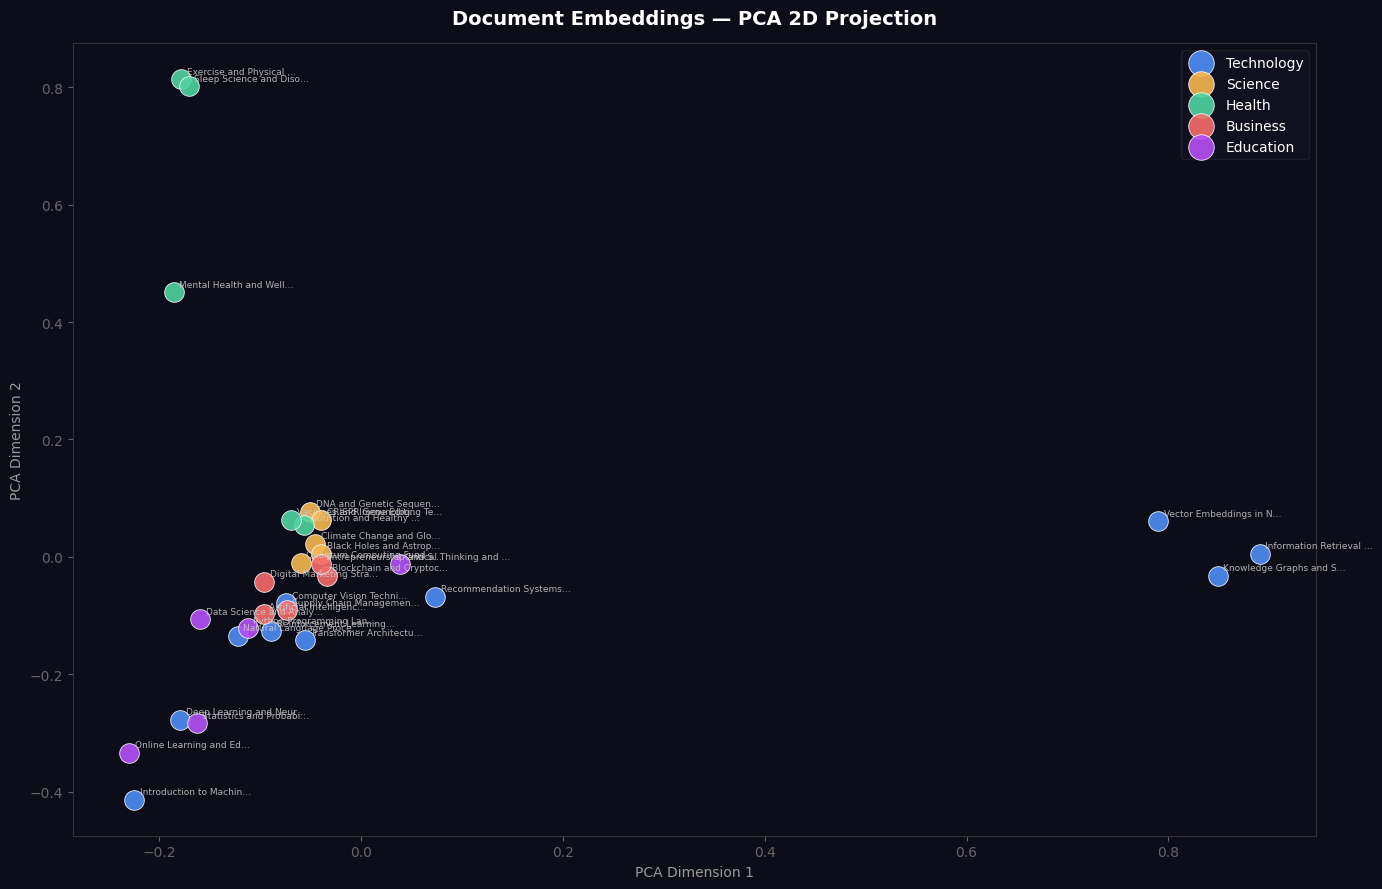

✅ Plot 1 saved: plot1_pca.png
   PCA explained variance: PC1=8.95%, PC2=7.41%


In [78]:
# ══════════════════════════════════════════════════════════
# PLOT 1 — PCA 2D Projection of Document Embeddings
# ══════════════════════════════════════════════════════════

pca_2d   = PCA(n_components=2, random_state=42)
pca_coords = pca_2d.fit_transform(lsa_vectors)

categories_list = df['category'].tolist()
titles_list     = df['title'].tolist()

fig, ax = plt.subplots(figsize=(14, 9))
dark_style(fig, ax, 'Document Embeddings — PCA 2D Projection',
           xlabel='PCA Dimension 1', ylabel='PCA Dimension 2')

for cat in CAT_COLORS:
    mask = np.array([c == cat for c in categories_list])
    ax.scatter(pca_coords[mask, 0], pca_coords[mask, 1],
               c=CAT_COLORS[cat], s=200, alpha=0.9, label=cat,
               edgecolors='white', linewidths=0.6, zorder=3)

for i, title in enumerate(titles_list):
    short = title[:22] + '…' if len(title) > 22 else title
    ax.annotate(short, (pca_coords[i, 0], pca_coords[i, 1]),
                fontsize=6.5, color='#CCCCCC', alpha=0.85,
                xytext=(4, 4), textcoords='offset points')

ax.legend(fontsize=10, framealpha=0.3, facecolor='#1A1A2E',
          edgecolor='#444', labelcolor='white', markerscale=1.3)
plt.tight_layout()
plt.savefig('plot1_pca.png', dpi=150, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 1 saved: plot1_pca.png")
print(f"   PCA explained variance: PC1={pca_2d.explained_variance_ratio_[0]:.2%}, PC2={pca_2d.explained_variance_ratio_[1]:.2%}")

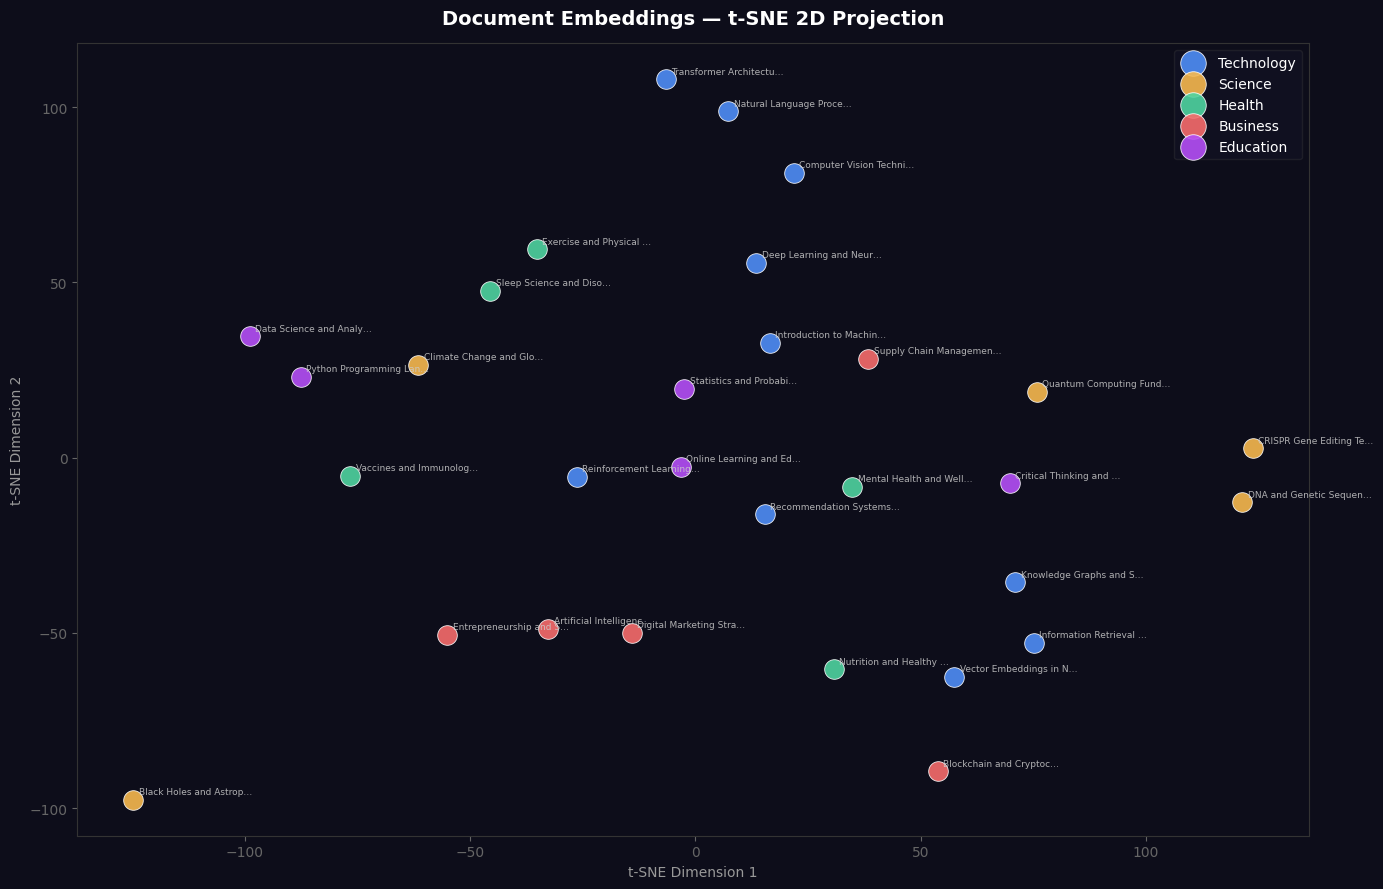

✅ Plot 2 saved: plot2_tsne.png


In [79]:
# ══════════════════════════════════════════════════════════
# PLOT 2 — t-SNE 2D Projection
# ══════════════════════════════════════════════════════════

tsne_model  = TSNE(n_components=2, random_state=42,
                   perplexity=min(10, len(lsa_vectors)-1), max_iter=1000)
tsne_coords = tsne_model.fit_transform(lsa_vectors)

fig, ax = plt.subplots(figsize=(14, 9))
dark_style(fig, ax, 'Document Embeddings — t-SNE 2D Projection',
           xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')

for cat in CAT_COLORS:
    mask = np.array([c == cat for c in categories_list])
    ax.scatter(tsne_coords[mask, 0], tsne_coords[mask, 1],
               c=CAT_COLORS[cat], s=200, alpha=0.9, label=cat,
               edgecolors='white', linewidths=0.6, zorder=3)

for i, title in enumerate(titles_list):
    short = title[:22] + '…' if len(title) > 22 else title
    ax.annotate(short, (tsne_coords[i, 0], tsne_coords[i, 1]),
                fontsize=6.5, color='#CCCCCC', alpha=0.85,
                xytext=(4, 4), textcoords='offset points')

ax.legend(fontsize=10, framealpha=0.3, facecolor='#1A1A2E',
          edgecolor='#444', labelcolor='white', markerscale=1.3)
plt.tight_layout()
plt.savefig('plot2_tsne.png', dpi=150, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 2 saved: plot2_tsne.png")

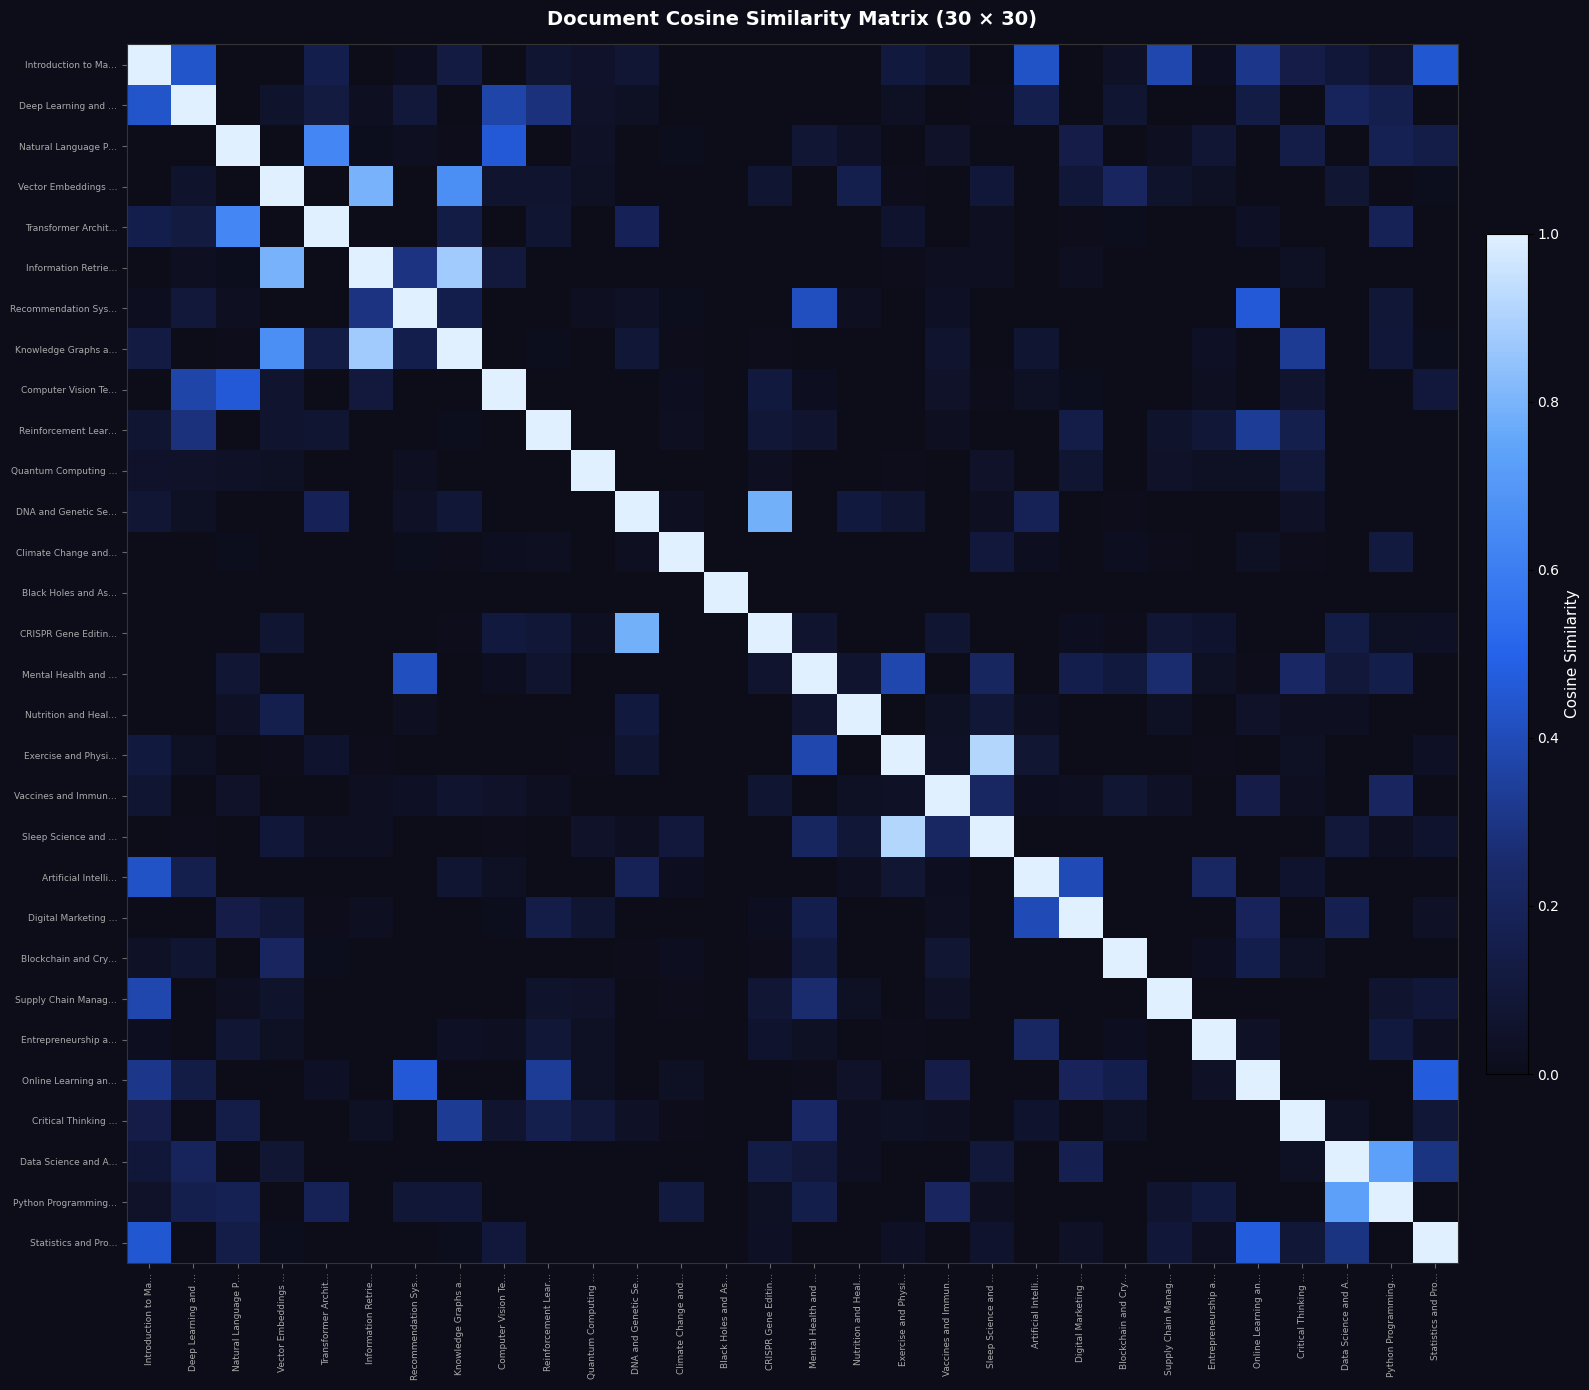

✅ Plot 3 saved: plot3_heatmap.png
   Max off-diagonal similarity: 0.9105
   Min similarity            : -0.2274


In [80]:
# ══════════════════════════════════════════════════════════
# PLOT 3 — Full Similarity Heatmap (30 × 30)
# ══════════════════════════════════════════════════════════

sim_matrix   = store.similarity_matrix()
titles_short = [t[:18] + '…' if len(t) > 18 else t for t in df['title']]

fig, ax = plt.subplots(figsize=(16, 14))
dark_style(fig, ax, 'Document Cosine Similarity Matrix (30 × 30)')

cmap = LinearSegmentedColormap.from_list('deep_blue',
       ['#0D0D1A', '#1a2a6c', '#2563eb', '#60a5fa', '#e0f0ff'])
im = ax.imshow(sim_matrix, cmap=cmap, vmin=0, vmax=1, aspect='auto')

ax.set_xticks(range(len(titles_short)))
ax.set_yticks(range(len(titles_short)))
ax.set_xticklabels(titles_short, rotation=90, fontsize=6.5, color='#AAAAAA')
ax.set_yticklabels(titles_short, fontsize=6.5, color='#AAAAAA')

cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('Cosine Similarity', color='white', fontsize=11)
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')

plt.tight_layout()
plt.savefig('plot3_heatmap.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 3 saved: plot3_heatmap.png")
print(f"   Max off-diagonal similarity: {np.max(sim_matrix - np.eye(len(sim_matrix))):.4f}")
print(f"   Min similarity            : {np.min(sim_matrix):.4f}")

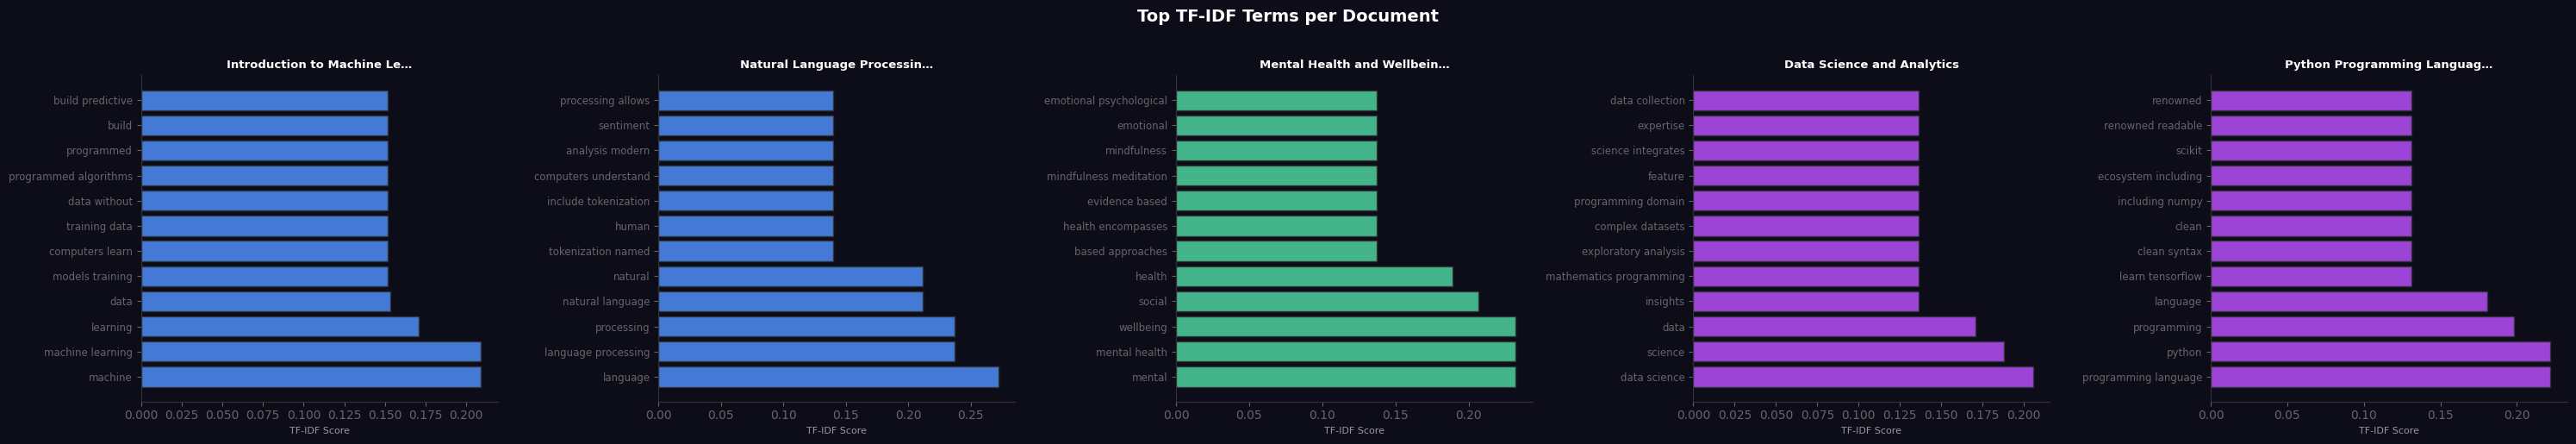

✅ Plot 4 saved: plot4_tfidf_terms.png


In [81]:
# ══════════════════════════════════════════════════════════
# PLOT 4 — Top TF-IDF Terms per Document
# ══════════════════════════════════════════════════════════

doc_ids_to_plot = [1, 3, 16, 28, 29]  # ML, NLP, Health, DataSci, Python
n = len(doc_ids_to_plot)

fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
fig.patch.set_facecolor('#0D0D1A')

for ax, doc_id in zip(axes, doc_ids_to_plot):
    idx    = store.id_to_idx[doc_id]
    row    = store.documents.iloc[idx]
    title  = row['title']
    cat    = row.get('category', '')
    color  = CAT_COLORS.get(cat, '#4F8EF7')

    # Get TF-IDF scores for this doc
    tfidf_row = tfidf_matrix[idx].toarray().flatten()
    top_idx   = np.argsort(tfidf_row)[::-1][:12]
    words     = [vocab[i] for i in top_idx if tfidf_row[i] > 0]
    scores    = [tfidf_row[i] for i in top_idx if tfidf_row[i] > 0]

    ax.barh(range(len(words)), scores, color=color, alpha=0.85, edgecolor='#333')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words, fontsize=8.5, color='white')
    short_title = (title[:26] + '…') if len(title) > 26 else title
    ax.set_title(short_title, fontsize=9.5, color='white', fontweight='bold')
    ax.set_facecolor('#0D0D1A')
    ax.tick_params(colors='#666')
    for sp in ax.spines.values(): sp.set_edgecolor('#333')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('TF-IDF Score', color='#999', fontsize=8)

fig.suptitle('Top TF-IDF Terms per Document', fontsize=14,
             color='white', fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plot4_tfidf_terms.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 4 saved: plot4_tfidf_terms.png")

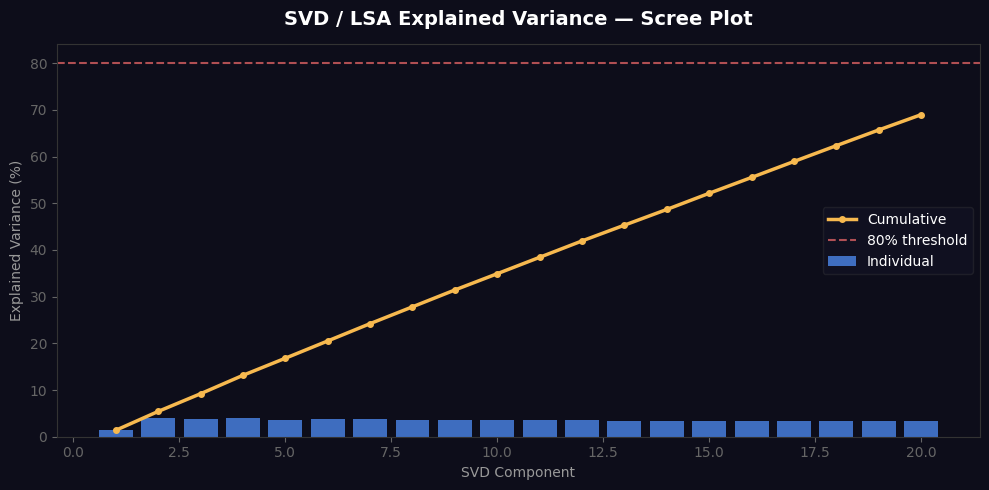

✅ Plot 5 saved: plot5_svd_variance.png
   Total explained variance (20 components): 68.96%
   Components needed for 80% variance: 1


In [82]:
# ══════════════════════════════════════════════════════════
# PLOT 5 — SVD Scree Plot (Explained Variance per Component)
# ══════════════════════════════════════════════════════════

evr = svd_model.explained_variance_ratio_
cum = np.cumsum(evr)

fig, ax = plt.subplots(figsize=(10, 5))
dark_style(fig, ax, 'SVD / LSA Explained Variance — Scree Plot',
           xlabel='SVD Component', ylabel='Explained Variance (%)')

ax.bar(range(1, len(evr)+1), evr * 100, color='#4F8EF7', alpha=0.75, label='Individual')
ax.plot(range(1, len(cum)+1), cum * 100, color='#F7B94F', linewidth=2.5,
        marker='o', markersize=4, label='Cumulative')
ax.axhline(80, color='#F76C6C', linestyle='--', alpha=0.7, label='80% threshold')
ax.legend(fontsize=10, framealpha=0.3, facecolor='#1A1A2E',
          edgecolor='#444', labelcolor='white')
plt.tight_layout()
plt.savefig('plot5_svd_variance.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 5 saved: plot5_svd_variance.png")
print(f"   Total explained variance ({N_COMPONENTS} components): {evr.sum():.2%}")
comp_80 = np.argmax(cum >= 0.80) + 1
print(f"   Components needed for 80% variance: {comp_80}")

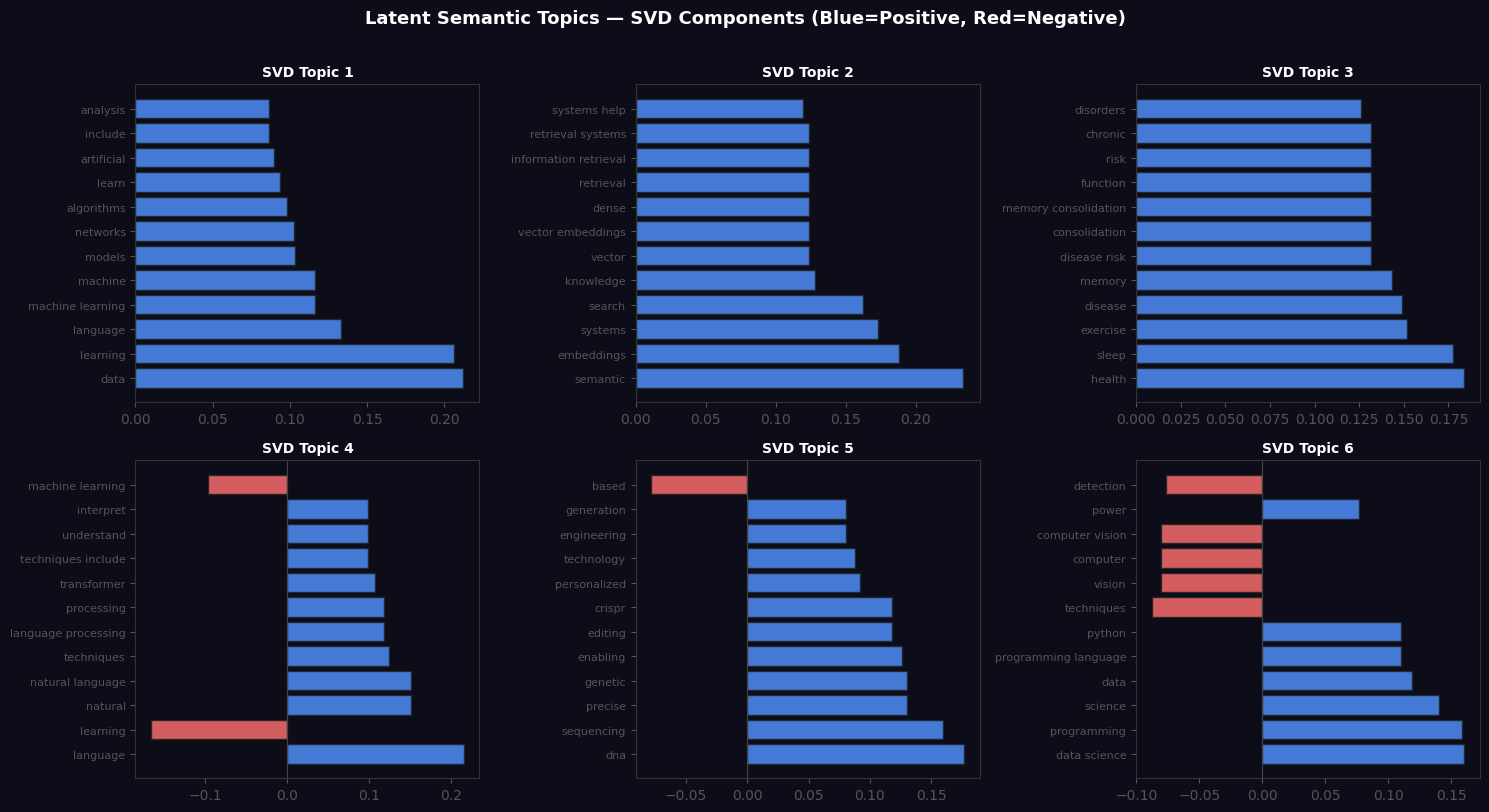

✅ Plot 6 saved: plot6_latent_topics.png


In [83]:
# ══════════════════════════════════════════════════════════
# PLOT 6 — Latent SVD Topics (Top Terms per Component)
# ══════════════════════════════════════════════════════════

n_show = min(6, len(svd_model.components_))
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.patch.set_facecolor('#0D0D1A')
axes = axes.flatten()

for i in range(n_show):
    ax = axes[i]
    ax.set_facecolor('#0D0D1A')
    comp    = svd_model.components_[i]
    top_idx = np.argsort(np.abs(comp))[::-1][:12]
    words   = [vocab[j] for j in top_idx]
    vals    = [comp[j] for j in top_idx]
    colors  = ['#4F8EF7' if v > 0 else '#F76C6C' for v in vals]

    ax.barh(range(len(words)), vals, color=colors, alpha=0.85, edgecolor='#222')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words, fontsize=8, color='white')
    ax.set_title(f'SVD Topic {i+1}', fontsize=10, color='white', fontweight='bold')
    ax.tick_params(colors='#555')
    for sp in ax.spines.values(): sp.set_edgecolor('#333')
    ax.axvline(0, color='#444', linewidth=0.8)

for j in range(n_show, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Latent Semantic Topics — SVD Components (Blue=Positive, Red=Negative)',
             fontsize=13, color='white', fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('plot6_latent_topics.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 6 saved: plot6_latent_topics.png")

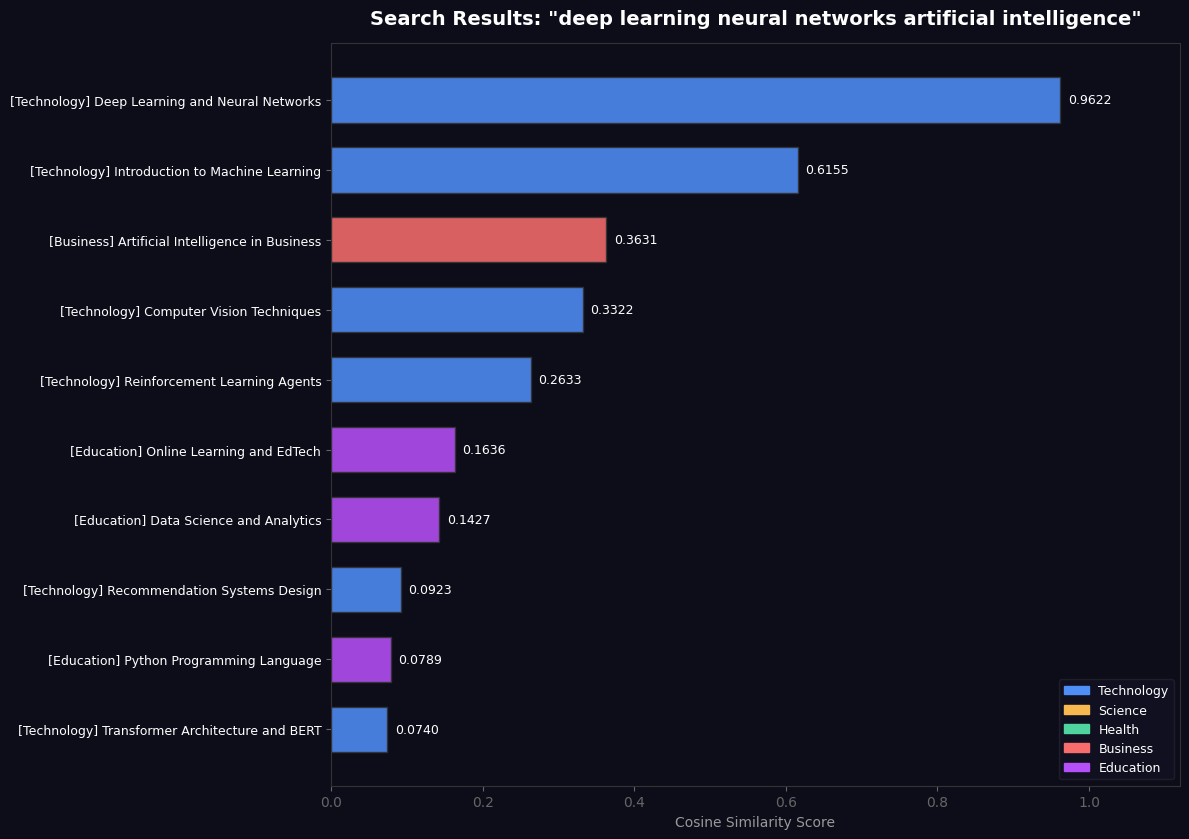

✅ Plot 7 saved: plot7_search_scores.png


In [84]:
# ══════════════════════════════════════════════════════════
# PLOT 7 — Search Result Similarity Scores
# ══════════════════════════════════════════════════════════

query   = "deep learning neural networks artificial intelligence"
result  = search_engine.search(query, top_k=10)
results = result['results']

titles_r  = [f"[{r['category']}] {r['title']}"[:55] for r in results]
scores_r  = [r['score'] for r in results]
colors_r  = [CAT_COLORS.get(r['category'], '#888') for r in results]

fig, ax = plt.subplots(figsize=(12, max(5, len(titles_r) * 0.75 + 1)))
dark_style(fig, ax, f'Search Results: "{query}"',
           xlabel='Cosine Similarity Score')

bars = ax.barh(range(len(titles_r)), scores_r, color=colors_r,
               alpha=0.88, edgecolor='#333', height=0.65)
ax.set_yticks(range(len(titles_r)))
ax.set_yticklabels(titles_r, fontsize=9, color='white')
ax.set_xlim(0, 1.12)

for i, s in enumerate(scores_r):
    ax.text(s + 0.01, i, f'{s:.4f}', va='center', fontsize=9, color='white')

ax.invert_yaxis()
patches = [mpatches.Patch(color=c, label=cat) for cat, c in CAT_COLORS.items()]
ax.legend(handles=patches, fontsize=9, framealpha=0.3, facecolor='#1A1A2E',
          edgecolor='#444', labelcolor='white', loc='lower right')
plt.tight_layout()
plt.savefig('plot7_search_scores.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 7 saved: plot7_search_scores.png")

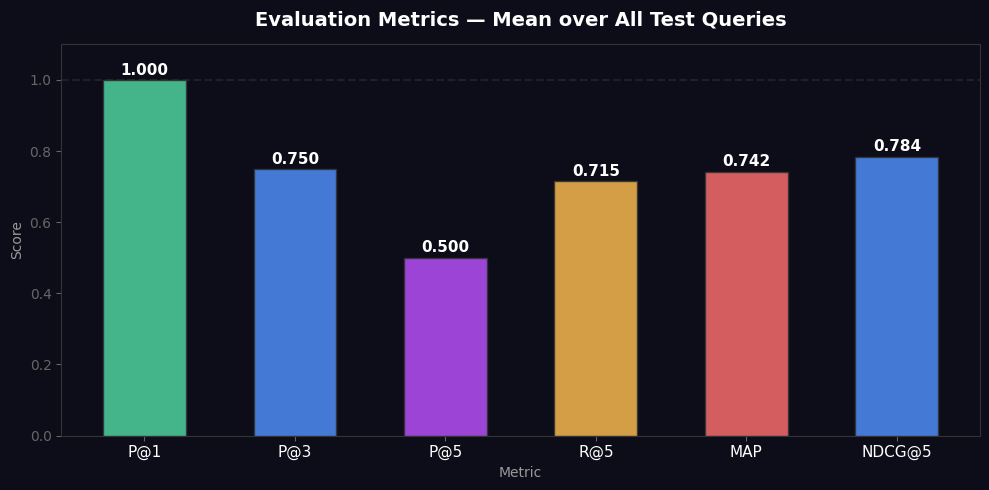

✅ Plot 8 saved: plot8_metrics.png


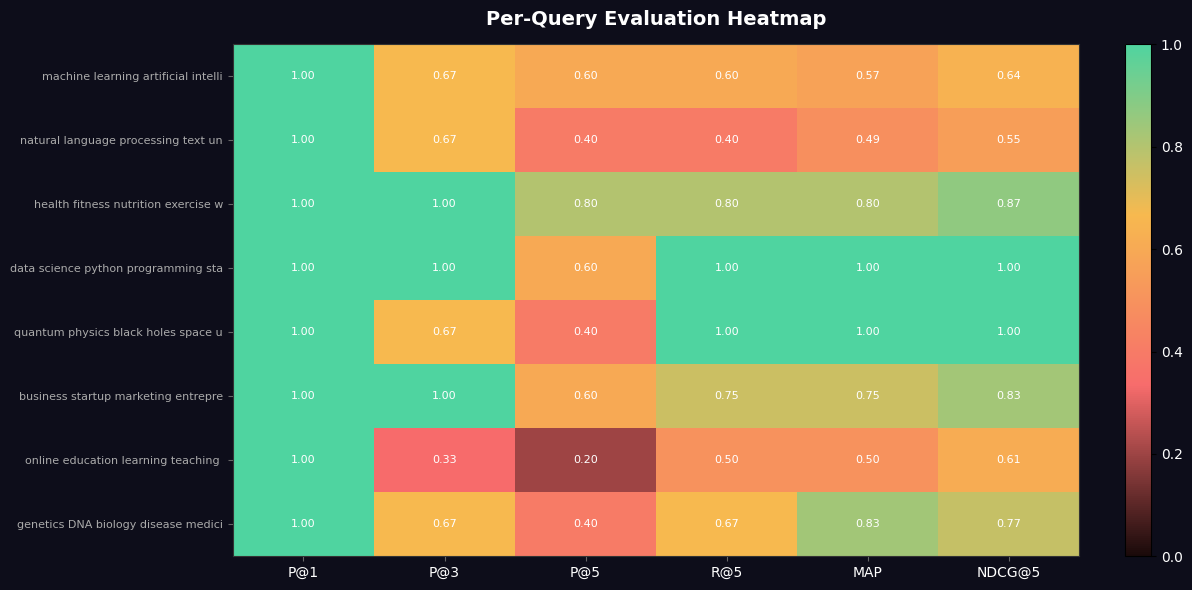

✅ Plot 8b saved: plot8b_eval_heatmap.png


In [85]:
# ══════════════════════════════════════════════════════════
# PLOT 8 — Evaluation Metrics Bar Chart
# ══════════════════════════════════════════════════════════

metric_cols = ['P@1', 'P@3', 'P@5', 'R@5', 'MAP', 'NDCG@5']
mean_vals   = eval_df[metric_cols].mean().values
metric_colors = ['#4FD4A0','#4F8EF7','#B54FF7','#F7B94F','#F76C6C','#4F8EF7']

fig, ax = plt.subplots(figsize=(10, 5))
dark_style(fig, ax, 'Evaluation Metrics — Mean over All Test Queries',
           xlabel='Metric', ylabel='Score')

bars = ax.bar(metric_cols, mean_vals, color=metric_colors, alpha=0.85,
              edgecolor='#333', width=0.55)

for bar, val in zip(bars, mean_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.015,
            f'{val:.3f}', ha='center', fontsize=11, color='white', fontweight='bold')

ax.set_ylim(0, 1.1)
ax.axhline(1.0, color='#333', linestyle='--', alpha=0.5)
ax.set_xticklabels(metric_cols, color='white', fontsize=11)
plt.tight_layout()
plt.savefig('plot8_metrics.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 8 saved: plot8_metrics.png")

# Also plot per-query heatmap
fig, ax = plt.subplots(figsize=(12, 6))
dark_style(fig, ax, 'Per-Query Evaluation Heatmap')
cmap2 = LinearSegmentedColormap.from_list('gr', ['#1A0A0A','#F76C6C','#F7B94F','#4FD4A0'])
data_matrix = eval_df[metric_cols].values
im = ax.imshow(data_matrix, cmap=cmap2, vmin=0, vmax=1, aspect='auto')
ax.set_xticks(range(len(metric_cols))); ax.set_xticklabels(metric_cols, color='white', fontsize=10)
ax.set_yticks(range(len(eval_df))); ax.set_yticklabels([q[:35] for q in eval_df['Query']], fontsize=8, color='#AAAAAA')
for i in range(data_matrix.shape[0]):
    for j in range(data_matrix.shape[1]):
        ax.text(j, i, f'{data_matrix[i,j]:.2f}', ha='center', va='center', fontsize=8, color='white')
cbar2 = fig.colorbar(im, ax=ax, fraction=0.03)
plt.setp(cbar2.ax.yaxis.get_ticklabels(), color='white')
plt.tight_layout()
plt.savefig('plot8b_eval_heatmap.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 8b saved: plot8b_eval_heatmap.png")

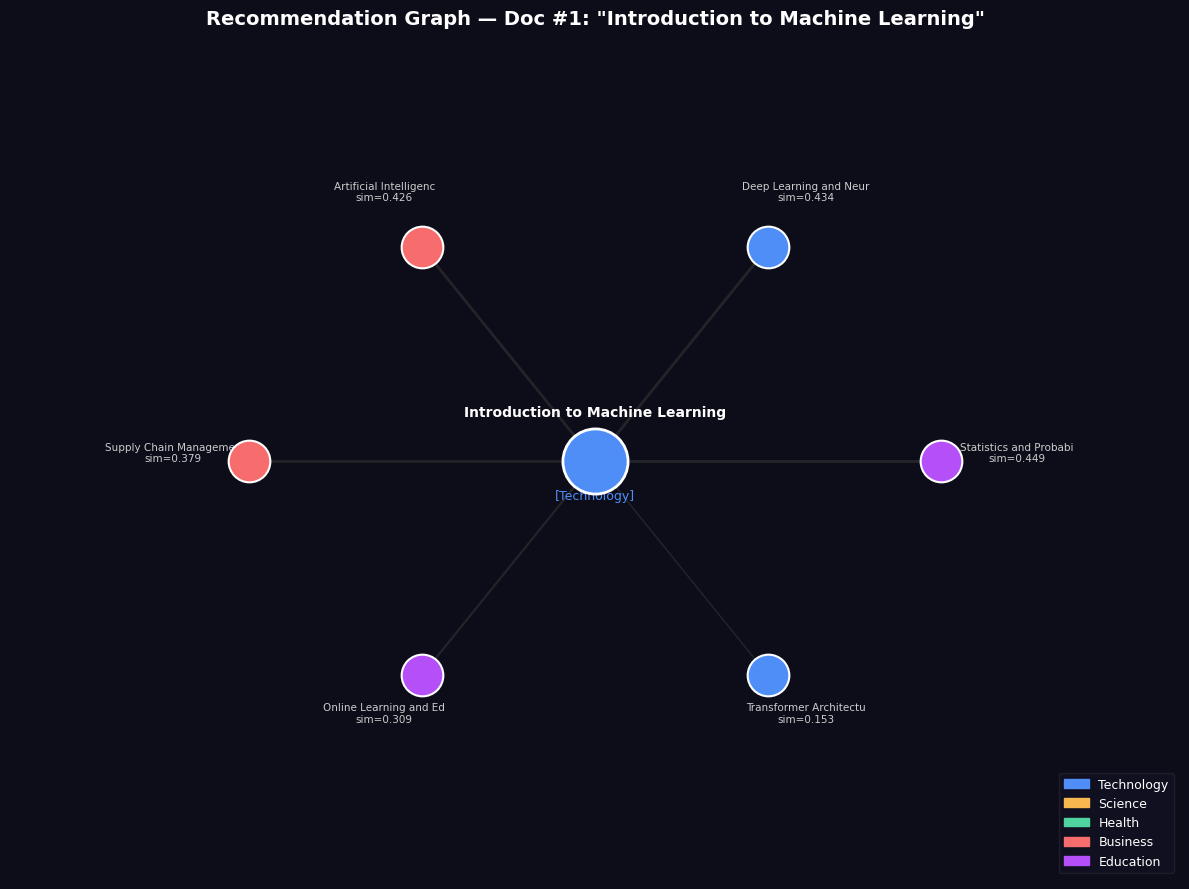

✅ Plot 9 saved: plot9_rec_graph.png


In [86]:
# ══════════════════════════════════════════════════════════
# PLOT 9 — Recommendation Star Graph
# ══════════════════════════════════════════════════════════

source_doc_id = 1   # Introduction to Machine Learning
recs          = recommender.recommend_for_doc(source_doc_id, top_k=6)
source_row    = store.documents.iloc[store.id_to_idx[source_doc_id]]
source_color  = CAT_COLORS.get(source_row.get('category',''), '#F7B94F')

fig, ax = plt.subplots(figsize=(12, 9))
dark_style(fig, ax, f'Recommendation Graph — Doc #{source_doc_id}: "{source_row["title"]}"')

# Center node
ax.scatter([0], [0], s=2200, c=source_color, zorder=5, edgecolors='white', linewidths=2)
ax.text(0, 0.12, source_row['title'], ha='center', fontsize=10,
        color='white', fontweight='bold')
ax.text(0, -0.1, f'[{source_row["category"]}]', ha='center',
        fontsize=9, color=source_color)

# Recommendation nodes
n      = len(recs)
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
for rec, angle in zip(recs, angles):
    x, y   = np.cos(angle) * 0.65, np.sin(angle) * 0.65
    rc     = CAT_COLORS.get(rec['category'], '#888')
    lw     = 0.5 + rec['score'] * 3.5
    ax.plot([0, x], [0, y], color='#333', linewidth=lw, alpha=0.6, zorder=2)
    ax.scatter([x], [y], s=900, c=rc, zorder=4, edgecolors='white', linewidths=1.5)
    label = rec['title'][:22] + '\n' + f"sim={rec['score']:.3f}"
    ax.text(x * 1.22, y * 1.22, label, ha='center', fontsize=7.5, color='#CCCCCC')

ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1); ax.axis('off')
patches = [mpatches.Patch(color=c, label=cat) for cat, c in CAT_COLORS.items()]
ax.legend(handles=patches, fontsize=9, framealpha=0.3, facecolor='#1A1A2E',
          edgecolor='#444', labelcolor='white', loc='lower right')
plt.tight_layout()
plt.savefig('plot9_rec_graph.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 9 saved: plot9_rec_graph.png")

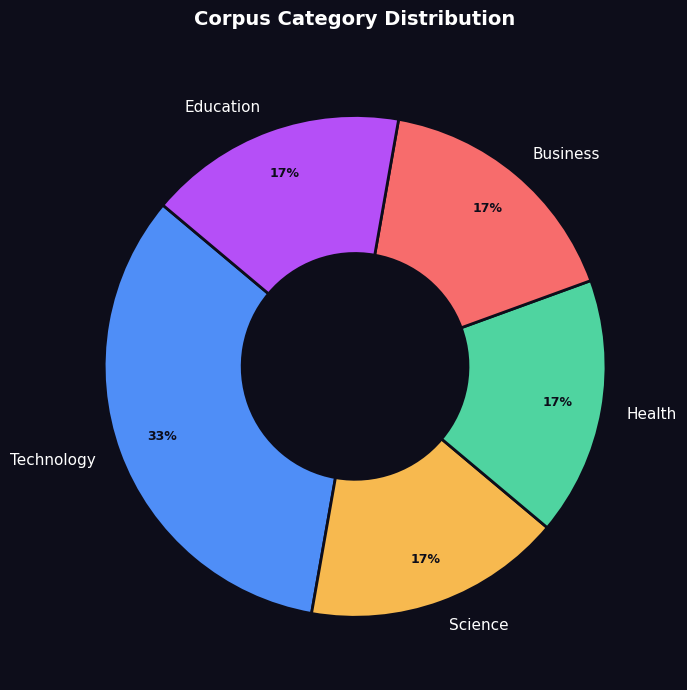

✅ Plot 10 saved: plot10_category_dist.png


In [87]:
# ══════════════════════════════════════════════════════════
# PLOT 10 — Category Distribution Donut Chart
# ══════════════════════════════════════════════════════════

cat_counts = df['category'].value_counts()
colors     = [CAT_COLORS.get(c, '#888') for c in cat_counts.index]

fig, ax = plt.subplots(figsize=(8, 7))
fig.patch.set_facecolor('#0D0D1A'); ax.set_facecolor('#0D0D1A')
wedges, texts, autotexts = ax.pie(
    cat_counts.values, labels=cat_counts.index, autopct='%1.0f%%',
    colors=colors, startangle=140, pctdistance=0.82,
    wedgeprops=dict(width=0.55, edgecolor='#0D0D1A', linewidth=2)
)
for t in texts:      t.set_color('white'); t.set_fontsize(11)
for a in autotexts:  a.set_color('#0D0D1A'); a.set_fontsize(9); a.set_fontweight('bold')
ax.set_title('Corpus Category Distribution', fontsize=14,
             color='white', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('plot10_category_dist.png', dpi=140, bbox_inches='tight', facecolor='#0D0D1A')
plt.show()
print("✅ Plot 10 saved: plot10_category_dist.png")